# Dataset Exploration: SwissDial

Dieses Notebook führt eine strukturierte Exploration des SwissDial-Datensatzes durch, um fundamentale Eigenschaften und Charakteristika zu identifizieren, die für die Modellentwicklung und das Training relevant sind.


In [1]:
import json
import sys
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Determine project root and notebook directory
# This works whether notebook is run from notebooks/ or project root
CURRENT_DIR = Path.cwd()

# Check if we're in the notebooks directory
if CURRENT_DIR.name == "notebooks":
    NOTEBOOK_DIR = CURRENT_DIR
    PROJECT_ROOT = CURRENT_DIR.parent
else:
    # If run from project root, check if notebooks/ exists
    notebooks_dir = CURRENT_DIR / "notebooks"
    if notebooks_dir.exists() and notebooks_dir.is_dir():
        NOTEBOOK_DIR = notebooks_dir
        PROJECT_ROOT = CURRENT_DIR
    else:
        # Fallback: assume we're in notebooks but it's not in the name
        NOTEBOOK_DIR = CURRENT_DIR
        PROJECT_ROOT = CURRENT_DIR.parent

# Add project root to path for imports
sys.path.insert(0, str(PROJECT_ROOT))
from src.utils.dataset import flatten_examples, load_swiss_german_data, split_data

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

# Define paths relative to project root
DATA_DIR = PROJECT_ROOT / "data"
JSON_FILES = {
    "numerics": DATA_DIR / "sentences_ch_de_numerics.json",
    "transcribed": DATA_DIR / "sentences_ch_de_transcribed.json",
}

# Dialects used in training
# NOTE: "ch_de" ist Hochdeutsch (Standarddeutsch), kein Schweizer Dialekt
# Es wird hier als Baseline/Referenz verwendet, aber für reine Dialektklassifikation
# sollte nur Schweizerdeutsch verwendet werden (z.B. mit "ch_ag" statt "ch_de")
# Die aktuelle Config verwendet "ch_de", das Teammitglieds-Notebook verwendet "ch_ag"
DIALECTS = ["ch_de", "ch_lu", "ch_be", "ch_zh", "ch_vs", "ch_bs", "ch_gr", "ch_sg"]
# Alternative (nur Schweizer Dialekte): ["ch_ag", "ch_lu", "ch_be", "ch_zh", "ch_vs", "ch_bs", "ch_gr", "ch_sg"]

# Split parameters (from config)
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
SEED = 42

print("Setup complete!")
print(f"Notebook directory: {NOTEBOOK_DIR}")
print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Data directory exists: {DATA_DIR.exists()}")
print(f"Available JSON files: {list(JSON_FILES.keys())}")

Setup complete!
Notebook directory: /home/btw/projects/SwissLP/notebooks
Project root: /home/btw/projects/SwissLP
Data directory: /home/btw/projects/SwissLP/data
Data directory exists: True
Available JSON files: ['numerics', 'transcribed']


## Schritt 1: Grundlegende Datensatz-Größe

**Frage:** Wie groß ist der Datensatz?


In [2]:
# Initialize dataset variable
dataset = None
main_file_path = None

# Explore data directory structure
print("Data directory contents:")
audio_dirs = []
json_files = []
other_files = []

for item in sorted(DATA_DIR.iterdir()):
    if item.is_dir():
        # Count audio files in dialect directories
        audio_count = 0
        if item.is_dir():
            audio_files = list(item.glob("*.wav"))
            audio_count = len(audio_files)
        audio_dirs.append((item.name, audio_count))
        print(f"  📁 {item.name}/ ({audio_count:,} WAV files)")
    elif item.is_file():
        size_mb = item.stat().st_size / (1024 * 1024)
        if item.suffix == ".json":
            json_files.append((item.name, size_mb))
        else:
            other_files.append((item.name, size_mb))
        print(f"  📄 {item.name} ({size_mb:.2f} MB)")

print("\n  Zusammenfassung:")
print(f"    Audio-Ordner (Dialekte): {len(audio_dirs) if audio_dirs else 0}")
print(f"    JSON-Dateien: {len(json_files) if json_files else 0}")
print(f"    Andere Dateien: {len(other_files) if other_files else 0}")

print("\n" + "=" * 70)

# Load and analyze JSON files
for name, path in JSON_FILES.items():
    if path.exists():
        print(f"\n{name.upper()} file:")
        print(f"  Path: {path}")
        size_mb = path.stat().st_size / (1024 * 1024)
        print(f"  File size: {size_mb:.2f} MB")

        with open(path, encoding="utf-8") as f:
            data = json.load(f)

        print(f"  Number of entries: {len(data):,}")

        # Estimate memory usage
        import sys

        memory_bytes = sys.getsizeof(data)
        for item in data[:100]:  # Sample for estimation
            memory_bytes += sys.getsizeof(item)
        memory_mb = memory_bytes / (1024 * 1024)
        print(f"  Estimated memory usage: ~{memory_mb:.2f} MB")

        # Store the numerics file as main dataset
        if name == "numerics":
            dataset = data
            main_file_path = path

print(f"\n{'=' * 70}")
if dataset is not None:
    print(f"Main dataset: {len(dataset):,} entries")
    print("\nHinweis: Der Datensatz enthält sowohl Text- als auch Audio-Daten.")
    print("  - Text: JSON-Dateien mit Transkriptionen")
    print("  - Audio: WAV-Dateien in Dialekt-Ordnern (ag/, be/, bs/, gr/, lu/, sg/, vs/, zh/)")
else:
    raise FileNotFoundError("Main dataset file not found!")

Data directory contents:
  📄 LICENSE.txt (0.00 MB)
  📄 README.txt (0.00 MB)
  📁 ag/ (2,748 WAV files)
  📁 be/ (2,700 WAV files)
  📁 bs/ (2,713 WAV files)
  📁 gr/ (10,475 WAV files)
  📁 lu/ (2,715 WAV files)
  📄 sentences_ch_de_numerics.json (4.51 MB)
  📄 sentences_ch_de_transcribed.json (4.57 MB)
  📁 sg/ (2,752 WAV files)
  📁 vs/ (2,753 WAV files)
  📁 zh/ (4,065 WAV files)

  Zusammenfassung:
    Audio-Ordner (Dialekte): 8
    JSON-Dateien: 2
    Andere Dateien: 2


NUMERICS file:
  Path: /home/btw/projects/SwissLP/data/sentences_ch_de_numerics.json
  File size: 4.51 MB
  Number of entries: 11,213
  Estimated memory usage: ~0.13 MB

TRANSCRIBED file:
  Path: /home/btw/projects/SwissLP/data/sentences_ch_de_transcribed.json
  File size: 4.57 MB
  Number of entries: 11,213
  Estimated memory usage: ~0.13 MB

Main dataset: 11,213 entries

Hinweis: Der Datensatz enthält sowohl Text- als auch Audio-Daten.
  - Text: JSON-Dateien mit Transkriptionen
  - Audio: WAV-Dateien in Dialekt-Ordnern (a

In [3]:
# These: Datensatz-Größe
print("=" * 70)
print("THESE: Grundlegende Datensatz-Größe")
print("=" * 70)

if dataset is not None and main_file_path is not None:
    num_entries = len(dataset)
    file_size_mb = main_file_path.stat().st_size / (1024 * 1024)

    # Bewertung der Größe
    if num_entries < 1000:
        size_evaluation = "klein"
    elif num_entries < 10000:
        size_evaluation = "mittel"
    else:
        size_evaluation = "groß"

    print("\nDer Datensatz besteht aus zwei JSON-Dateien:")
    print("  - sentences_ch_de_numerics.json (mit numerischen Werten)")
    print(
        "  - sentences_ch_de_transcribed.json (ohne numerische Werte, alle Zahlen transkribiert)"
    )
    print(f"\nDer Hauptdatensatz (sentences_ch_de_numerics.json) enthält {num_entries:,} Einträge")
    print(f"und hat eine Dateigröße von {file_size_mb:.2f} MB.")
    print(f"\nDer Datensatz ist damit {size_evaluation} für ein Machine-Learning-Projekt")
    print("zur Dialektklassifikation.")
else:
    print("Fehler: Datensatz nicht geladen!")

THESE: Grundlegende Datensatz-Größe

Der Datensatz besteht aus zwei JSON-Dateien:
  - sentences_ch_de_numerics.json (mit numerischen Werten)
  - sentences_ch_de_transcribed.json (ohne numerische Werte, alle Zahlen transkribiert)

Der Hauptdatensatz (sentences_ch_de_numerics.json) enthält 11,213 Einträge
und hat eine Dateigröße von 4.51 MB.

Der Datensatz ist damit groß für ein Machine-Learning-Projekt
zur Dialektklassifikation.


## Schritt 2: Datenstruktur

**Frage:** Aus was besteht der Datensatz?


In [4]:
# Analyze data structure
print("Example entry structure:")
example = dataset[0]
print(json.dumps(example, indent=2, ensure_ascii=False))

print("\n" + "=" * 70)
print("Field analysis:")
print(f"  Keys in each entry: {list(example.keys())}")
print(f"  Number of fields: {len(example.keys())}")

# Check if all entries have the same structure
all_keys = [set(entry.keys()) for entry in dataset]
unique_key_sets = set(tuple(sorted(keys)) for keys in all_keys)
print(f"  Unique key combinations: {len(unique_key_sets)}")
if len(unique_key_sets) == 1:
    print("  ✓ All entries have identical structure")
else:
    print("  ⚠ Entries have different structures:")
    for keys in unique_key_sets:
        count = sum(1 for entry_keys in all_keys if set(entry_keys) == keys)
        print(f"    - {sorted(keys)}: {count} entries")

# Analyze ID field
ids = [entry.get("id") for entry in dataset]
print("\nID field analysis:")
print(f"  Unique IDs: {len(set(ids))}")
print(f"  ID range: {min(ids)} - {max(ids)}")
print(f"  Missing IDs: {ids.count(None)}")

# Check for 'thema' field
if "thema" in example:
    themen = [entry.get("thema") for entry in dataset]
    print("\nThema field:")
    print(f"  Unique Themen: {len(set(themen))}")
    print(f"  Missing Themen: {themen.count(None)}")

Example entry structure:
{
  "id": 0,
  "de": "Derzeit ist er in «Parasite», dem Siegerfilm von Cannes, zu sehen.",
  "ch_sg": "Zur Ziit isch er in \"Parasite\", en Siegerfilm vo Cannes, zgseh.",
  "ch_be": "Momentan ischer in \"Parasite\" z gseh, em Siegerfium vo Cannes.",
  "ch_gr": "Derziit isch er in \"Parasite\", am Siegerfilm vu Cannes, z gseh.",
  "ch_zh": "Momentan chamer ihn in \"Parasite\", em Siegerfilm vo Cannes, gseh.",
  "ch_vs": "Derzit ischer in \"Parasite\", dum Siegerfilm va Cannes, zgseh.",
  "ch_bs": "Zur Ziit isch är in \"Parasite\", em Siigerfilm vo Cannes, z gseh.",
  "ch_ag": "Em Moment escher en \"OParasite\", de Siegerfelm fo Cannes z'gseh.",
  "ch_lu": "Momentan escher en \"Parasite\", em Sigerfelm vo Cannes, zgseh.",
  "thema": "kultur"
}

Field analysis:
  Keys in each entry: ['id', 'de', 'ch_sg', 'ch_be', 'ch_gr', 'ch_zh', 'ch_vs', 'ch_bs', 'ch_ag', 'ch_lu', 'thema']
  Number of fields: 11
  Unique key combinations: 38
  ⚠ Entries have different structures

In [5]:
# These: Datenstruktur
print("=" * 70)
print("THESE: Datenstruktur")
print("=" * 70)

if dataset is not None and len(dataset) > 0:
    example = dataset[0]
    has_thema = "thema" in example

    print("\nDer Datensatz besteht aus einer Liste von JSON-Objekten, wobei jedes Objekt:")
    print("  - einen eindeutigen numerischen Identifikator ('id')")
    print("  - eine Hochdeutsch-Version ('de')")
    print("  - mehrere Schweizerdeutsch-Dialektversionen (z.B. 'ch_sg', 'ch_be', 'ch_gr', etc.)")
    if has_thema:
        print("  - ein optionales Themenfeld ('thema')")
    print("\nJeder Eintrag repräsentiert denselben Satz in verschiedenen Dialektvarianten,")
    print("was eine parallele Korpusstruktur bildet, die für die Dialektklassifikation ideal ist.")
else:
    print("Fehler: Datensatz nicht geladen!")

THESE: Datenstruktur

Der Datensatz besteht aus einer Liste von JSON-Objekten, wobei jedes Objekt:
  - einen eindeutigen numerischen Identifikator ('id')
  - eine Hochdeutsch-Version ('de')
  - mehrere Schweizerdeutsch-Dialektversionen (z.B. 'ch_sg', 'ch_be', 'ch_gr', etc.)
  - ein optionales Themenfeld ('thema')

Jeder Eintrag repräsentiert denselben Satz in verschiedenen Dialektvarianten,
was eine parallele Korpusstruktur bildet, die für die Dialektklassifikation ideal ist.


## Schritt 3: Dialekt-Verfügbarkeit

**Frage:** Welche Dialekte sind im Datensatz vorhanden?


In [6]:
# Extract all dialect keys from the dataset
all_dialect_keys = set()
dialect_counts = Counter()

for entry in dataset:
    # Get all keys that start with 'ch_' or are 'de'
    for key in entry.keys():
        if key.startswith("ch_") or key == "de":
            all_dialect_keys.add(key)
            if key in entry and entry[key] is not None:
                dialect_counts[key] += 1

print("Available dialects in dataset:")
print("=" * 70)
for dialect in sorted(all_dialect_keys):
    count = dialect_counts[dialect]
    percentage = (count / len(dataset)) * 100
    status = "✓" if count == len(dataset) else "⚠"
    print(f"  {status} {dialect:8s}: {count:6,} entries ({percentage:5.1f}%)")

print(f"\nTotal dialects found: {len(all_dialect_keys)}")
print(f"Dialects used in training: {DIALECTS}")
print(f"Dialects in dataset but not in training: {sorted(all_dialect_keys - set(DIALECTS))}")
print(f"Dialects in training but not in dataset: {sorted(set(DIALECTS) - all_dialect_keys)}")

# Important note about ch_de vs ch_ag
print("\n⚠️  WICHTIGER HINWEIS:")
if "ch_de" in DIALECTS:
    print("  - 'ch_de' (bzw. 'de' im JSON) ist HOCHDEUTSCH, kein Schweizer Dialekt")
    print("  - Es wird als Baseline/Referenz verwendet")
    print("  - Für reine Dialektklassifikation sollte 'ch_ag' (Aargau) verwendet werden")
if "ch_ag" in all_dialect_keys and "ch_ag" not in DIALECTS:
    print("  - 'ch_ag' (Aargau) ist im Datensatz vorhanden, aber nicht in der Config")
    print("  - Das Teammitglieds-Notebook verwendet 'ch_ag' statt 'ch_de'")

Available dialects in dataset:
  ⚠ ch_ag   :  2,748 entries ( 24.5%)
  ⚠ ch_be   :  2,700 entries ( 24.1%)
  ⚠ ch_bs   :  2,713 entries ( 24.2%)
  ⚠ ch_gr   : 10,475 entries ( 93.4%)
  ⚠ ch_lu   :  2,715 entries ( 24.2%)
  ⚠ ch_sg   :  2,752 entries ( 24.5%)
  ⚠ ch_vs   :  2,753 entries ( 24.6%)
  ⚠ ch_zh   :  4,065 entries ( 36.3%)
  ✓ de      : 11,213 entries (100.0%)

Total dialects found: 9
Dialects used in training: ['ch_de', 'ch_lu', 'ch_be', 'ch_zh', 'ch_vs', 'ch_bs', 'ch_gr', 'ch_sg']
Dialects in dataset but not in training: ['ch_ag', 'de']
Dialects in training but not in dataset: ['ch_de']

⚠️  WICHTIGER HINWEIS:
  - 'ch_de' (bzw. 'de' im JSON) ist HOCHDEUTSCH, kein Schweizer Dialekt
  - Es wird als Baseline/Referenz verwendet
  - Für reine Dialektklassifikation sollte 'ch_ag' (Aargau) verwendet werden
  - 'ch_ag' (Aargau) ist im Datensatz vorhanden, aber nicht in der Config
  - Das Teammitglieds-Notebook verwendet 'ch_ag' statt 'ch_de'


In [ ]:
# These: Dialekt-Verfügbarkeit
# Diese Zelle formuliert die These zur Dialekt-Verfügbarkeit basierend auf den Analyseergebnissen
print("=" * 70)
print("THESE: Dialekt-Verfügbarkeit")
print("=" * 70)

if dataset is not None:
    # Calculate percentages
    percentages = [
        (dialect_counts.get(d, 0) / len(dataset)) * 100 for d in sorted(all_dialect_keys)
    ]
    min_pct = min(percentages) if percentages else 0
    max_pct = max(percentages) if percentages else 0

    # Determine if coverage is complete
    all_100_pct = all(pct == 100.0 for pct in percentages)
    coverage_eval = "vollständige" if all_100_pct else "unvollständige"

    dialects_list_str = ", ".join(sorted(all_dialect_keys))
    training_dialects_str = ", ".join(DIALECTS)

    print(f"\nDer Datensatz enthält {len(all_dialect_keys)} verschiedene Dialektvarianten:")
    print(f"  {dialects_list_str}")
    print(f"\nVon diesen sind {len(DIALECTS)} für das Training konfiguriert:")
    print(f"  {training_dialects_str}")
    print(f"\nDie Verfügbarkeit der Dialekte variiert zwischen {min_pct:.1f}% und {max_pct:.1f}%")
    print(f"der Einträge, was auf {coverage_eval} Abdeckung hinweist.")
else:
    print("Fehler: Datensatz nicht geladen!")

THESE: Dialekt-Verfügbarkeit

Der Datensatz enthält 9 verschiedene Dialektvarianten:
  ch_ag, ch_be, ch_bs, ch_gr, ch_lu, ch_sg, ch_vs, ch_zh, de

Von diesen sind 8 für das Training konfiguriert:
  ch_de, ch_lu, ch_be, ch_zh, ch_vs, ch_bs, ch_gr, ch_sg

Die Verfügbarkeit der Dialekte variiert zwischen 24.1% und 100.0%
der Einträge, was auf unvollständige Abdeckung hinweist.


## Schritt 4: Dialekt-Verteilung

**Frage:** Wie viele Datenpunkte gibt es für die verschiedenen Dialekte?


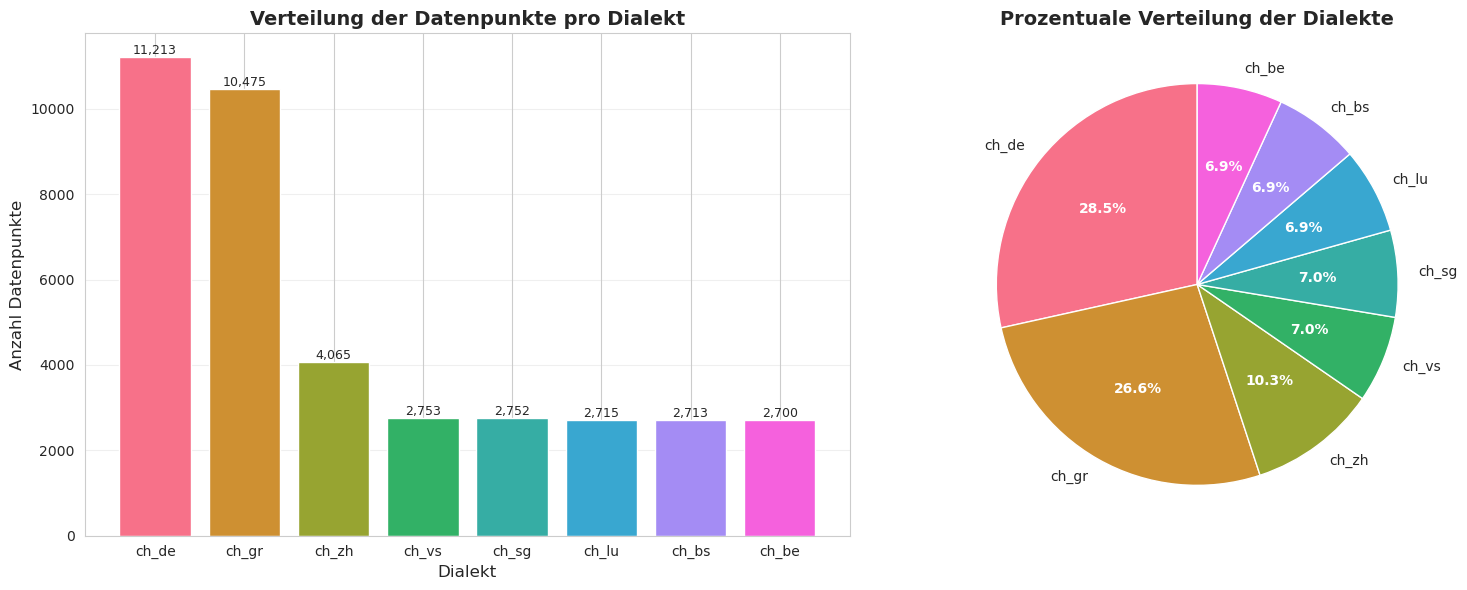

Statistische Zusammenfassung:
  Gesamtanzahl Datenpunkte (nach Flattening): 39,386
  Durchschnitt pro Dialekt: 4923.2
  Median pro Dialekt: 2752.5
  Minimum: 2,700 (ch_be)
  Maximum: 11,213 (ch_de)
  Standardabweichung: 3450.5

  Klassen-Ungleichgewicht (max/min): 4.15:1
  ⚠ Signifikantes Klassen-Ungleichgewicht erkannt!


In [8]:
# Count data points per dialect (after flattening)
# Map ch_de to de for data access
dialect_counts_flat = {}
for dialect in DIALECTS:
    data_key = "de" if dialect == "ch_de" else dialect
    count = sum(1 for entry in dataset if data_key in entry and entry[data_key] is not None)
    dialect_counts_flat[dialect] = count

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
dialects_sorted = sorted(dialect_counts_flat.items(), key=lambda x: x[1], reverse=True)
dialects_names = [d[0] for d in dialects_sorted]
dialects_counts = [d[1] for d in dialects_sorted]

bars = ax1.bar(
    dialects_names, dialects_counts, color=sns.color_palette("husl", len(dialects_names))
)
ax1.set_xlabel("Dialekt", fontsize=12)
ax1.set_ylabel("Anzahl Datenpunkte", fontsize=12)
ax1.set_title("Verteilung der Datenpunkte pro Dialekt", fontsize=14, fontweight="bold")
ax1.grid(axis="y", alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{int(height):,}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# Pie chart
colors = sns.color_palette("husl", len(dialects_names))
wedges, texts, autotexts = ax2.pie(
    dialects_counts, labels=dialects_names, autopct="%1.1f%%", colors=colors, startangle=90
)
ax2.set_title("Prozentuale Verteilung der Dialekte", fontsize=14, fontweight="bold")

# Improve text readability
for autotext in autotexts:
    autotext.set_color("white")
    autotext.set_fontweight("bold")

plt.tight_layout()
plt.show()

# Print statistics
print("Statistische Zusammenfassung:")
print("=" * 70)
print(f"  Gesamtanzahl Datenpunkte (nach Flattening): {sum(dialect_counts_flat.values()):,}")
print(f"  Durchschnitt pro Dialekt: {np.mean(list(dialect_counts_flat.values())):.1f}")
print(f"  Median pro Dialekt: {np.median(list(dialect_counts_flat.values())):.1f}")
min_dialect = min(dialect_counts_flat.items(), key=lambda x: x[1])
max_dialect = max(dialect_counts_flat.items(), key=lambda x: x[1])
print(f"  Minimum: {min_dialect[1]:,} ({min_dialect[0]})")
print(f"  Maximum: {max_dialect[1]:,} ({max_dialect[0]})")
print(f"  Standardabweichung: {np.std(list(dialect_counts_flat.values())):.1f}")

# Check for class imbalance
max_count = max(dialect_counts_flat.values())
min_count = min(dialect_counts_flat.values())
imbalance_ratio = max_count / min_count if min_count > 0 else float("inf")
print(f"\n  Klassen-Ungleichgewicht (max/min): {imbalance_ratio:.2f}:1")
if imbalance_ratio > 2.0:
    print("  ⚠ Signifikantes Klassen-Ungleichgewicht erkannt!")
else:
    print("  ✓ Relativ ausgeglichene Klassenverteilung")

In [ ]:
# These: Dialekt-Verteilung
# Diese Zelle formuliert die These zur Dialekt-Verteilung basierend auf den Analyseergebnissen
print("=" * 70)
print("THESE: Dialekt-Verteilung")
print("=" * 70)

if dialect_counts_flat:
    total_points = sum(dialect_counts_flat.values())
    avg_points = np.mean(list(dialect_counts_flat.values()))
    imbalance_ratio = max(dialect_counts_flat.values()) / min(dialect_counts_flat.values())

    # Determine balance
    if imbalance_ratio <= 1.5:
        balance_desc = "ausgeglichen"
        balance_eval = "akzeptabel"
    elif imbalance_ratio <= 2.0:
        balance_desc = "relativ ausgeglichen"
        balance_eval = "akzeptabel"
    else:
        balance_desc = "unausgeglichen"
        balance_eval = "problematisch"

    max_dialect = max(dialect_counts_flat.items(), key=lambda x: x[1])
    min_dialect = min(dialect_counts_flat.items(), key=lambda x: x[1])

    print("\nDie Verteilung der Datenpunkte über die verschiedenen Dialekte zeigt eine")
    print(f"{balance_desc} Verteilung.")
    print("\nNach dem Flattening (ein Datenpunkt pro Dialekt-Version pro Satz) ergeben")
    print(f"sich insgesamt {total_points:,} Datenpunkte, mit einem Durchschnitt von")
    print(f"{avg_points:.1f} Datenpunkten pro Dialekt.")
    print(f"\nDas Klassen-Ungleichgewicht beträgt {imbalance_ratio:.2f}:1, was {balance_eval}")
    print("für die Modellentwicklung ist.")
    print(f"\nDie Dialekte {max_dialect[0]} und {min_dialect[0]} haben die meisten bzw.")
    print(f"wenigsten Datenpunkte mit {max_dialect[1]:,} bzw. {min_dialect[1]:,}.")
else:
    print("Fehler: Dialekt-Verteilung nicht berechnet!")

THESE: Dialekt-Verteilung

Die Verteilung der Datenpunkte über die verschiedenen Dialekte zeigt eine
unausgeglichen Verteilung.

Nach dem Flattening (ein Datenpunkt pro Dialekt-Version pro Satz) ergeben
sich insgesamt 39,386 Datenpunkte, mit einem Durchschnitt von
4923.2 Datenpunkten pro Dialekt.

Das Klassen-Ungleichgewicht beträgt 4.15:1, was problematisch
für die Modellentwicklung ist.

Die Dialekte ch_de und ch_be haben die meisten bzw.
wenigsten Datenpunkte mit 11,213 bzw. 2,700.


## Schritt 5: Vollständigkeit

**Frage:** Sind alle Dialekte für alle Sätze vorhanden?


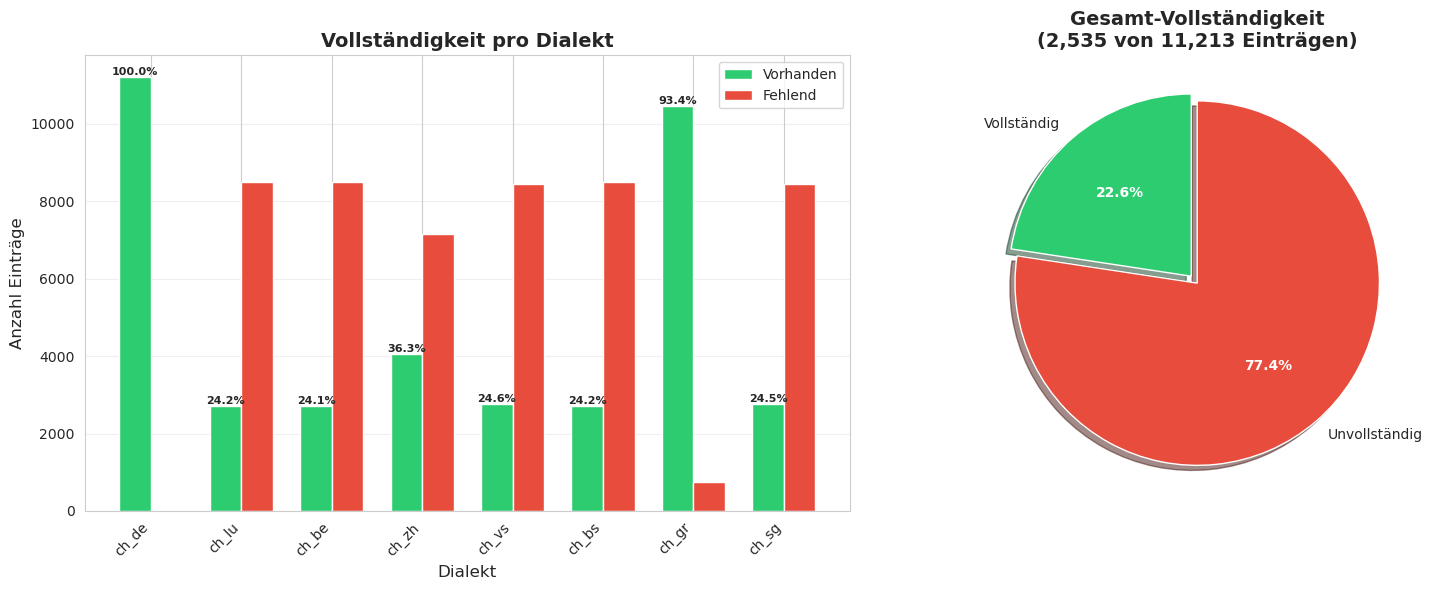

Vollständigkeits-Analyse:
  Einträge mit ALLEN erforderlichen Dialekten: 2,535 (22.61%)
  Einträge mit fehlenden Dialekten: 8,678 (77.39%)

  Beispiel-Einträge mit fehlenden Dialekten (erste 10):
    ID 7: fehlt ['ch_bs']
    ID 10: fehlt ['ch_bs']
    ID 19: fehlt ['ch_be']
    ID 30: fehlt ['ch_bs']
    ID 37: fehlt ['ch_zh']
    ID 45: fehlt ['ch_be']
    ID 62: fehlt ['ch_lu', 'ch_be', 'ch_zh', 'ch_bs', 'ch_gr']
    ID 77: fehlt ['ch_bs']
    ID 79: fehlt ['ch_lu']
    ID 81: fehlt ['ch_lu']

  Vollständigkeit pro Dialekt:
    ch_de   : 11,213/11,213 (100.0%)
    ch_lu   :  2,715/11,213 ( 24.2%)
    ch_be   :  2,700/11,213 ( 24.1%)
    ch_zh   :  4,065/11,213 ( 36.3%)
    ch_vs   :  2,753/11,213 ( 24.6%)
    ch_bs   :  2,713/11,213 ( 24.2%)
    ch_gr   : 10,475/11,213 ( 93.4%)
    ch_sg   :  2,752/11,213 ( 24.5%)


In [9]:
# Check completeness: how many entries have all required dialects?
completeness_stats = {}

for dialect in DIALECTS:
    data_key = "de" if dialect == "ch_de" else dialect
    missing_count = sum(
        1
        for entry in dataset
        if data_key not in entry or entry[data_key] is None or entry[data_key] == ""
    )
    completeness_stats[dialect] = {
        "present": len(dataset) - missing_count,
        "missing": missing_count,
        "completeness_pct": ((len(dataset) - missing_count) / len(dataset)) * 100,
    }

# Overall completeness: entries that have ALL required dialects
entries_with_all_dialects = 0
entries_missing_dialects = []

for entry in dataset:
    has_all = True
    missing = []
    for dialect in DIALECTS:
        data_key = "de" if dialect == "ch_de" else dialect
        if data_key not in entry or entry[data_key] is None or entry[data_key] == "":
            has_all = False
            missing.append(dialect)

    if has_all:
        entries_with_all_dialects += 1
    else:
        entries_missing_dialects.append((entry.get("id"), missing))

overall_completeness = (entries_with_all_dialects / len(dataset)) * 100

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Completeness per dialect
dialects_list = list(completeness_stats.keys())
present_counts = [completeness_stats[d]["present"] for d in dialects_list]
missing_counts = [completeness_stats[d]["missing"] for d in dialects_list]
completeness_pcts = [completeness_stats[d]["completeness_pct"] for d in dialects_list]

x = np.arange(len(dialects_list))
width = 0.35

bars1 = ax1.bar(x - width / 2, present_counts, width, label="Vorhanden", color="#2ecc71")
bars2 = ax1.bar(x + width / 2, missing_counts, width, label="Fehlend", color="#e74c3c")

ax1.set_xlabel("Dialekt", fontsize=12)
ax1.set_ylabel("Anzahl Einträge", fontsize=12)
ax1.set_title("Vollständigkeit pro Dialekt", fontsize=14, fontweight="bold")
ax1.set_xticks(x)
ax1.set_xticklabels(dialects_list, rotation=45, ha="right")
ax1.legend()
ax1.grid(axis="y", alpha=0.3)

# Add percentage labels
for i, (bar1, bar2, pct) in enumerate(zip(bars1, bars2, completeness_pcts)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    total = height1 + height2
    ax1.text(
        bar1.get_x() + bar1.get_width() / 2.0,
        height1,
        f"{pct:.1f}%",
        ha="center",
        va="bottom",
        fontsize=8,
        fontweight="bold",
    )

# Overall completeness pie chart
sizes = [entries_with_all_dialects, len(dataset) - entries_with_all_dialects]
labels = ["Vollständig", "Unvollständig"]
colors_pie = ["#2ecc71", "#e74c3c"]
explode = (0.05, 0)

wedges, texts, autotexts = ax2.pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors_pie,
    autopct="%1.1f%%",
    shadow=True,
    startangle=90,
)
ax2.set_title(
    f"Gesamt-Vollständigkeit\n({entries_with_all_dialects:,} von {len(dataset):,} Einträgen)",
    fontsize=14,
    fontweight="bold",
)

for autotext in autotexts:
    autotext.set_color("white")
    autotext.set_fontweight("bold")

plt.tight_layout()
plt.show()

# Print detailed statistics
print("Vollständigkeits-Analyse:")
print("=" * 70)
print(
    f"  Einträge mit ALLEN erforderlichen Dialekten: {entries_with_all_dialects:,} ({overall_completeness:.2f}%)"
)
print(
    f"  Einträge mit fehlenden Dialekten: {len(entries_missing_dialects):,} ({100 - overall_completeness:.2f}%)"
)

if entries_missing_dialects:
    print("\n  Beispiel-Einträge mit fehlenden Dialekten (erste 10):")
    for entry_id, missing in entries_missing_dialects[:10]:
        print(f"    ID {entry_id}: fehlt {missing}")

print("\n  Vollständigkeit pro Dialekt:")
for dialect in DIALECTS:
    stats = completeness_stats[dialect]
    print(
        f"    {dialect:8s}: {stats['present']:6,}/{len(dataset):6,} ({stats['completeness_pct']:5.1f}%)"
    )

In [ ]:
# These: Vollständigkeit
# Diese Zelle formuliert die These zur Vollständigkeit basierend auf den Analyseergebnissen
print("=" * 70)
print("THESE: Vollständigkeit")
print("=" * 70)

if completeness_stats:
    completeness_pcts = [completeness_stats[d]["completeness_pct"] for d in DIALECTS]
    min_completeness = min(completeness_pcts)
    max_completeness = max(completeness_pcts)

    min_dialect_complete = min(completeness_stats.items(), key=lambda x: x[1]["completeness_pct"])
    max_dialect_complete = max(completeness_stats.items(), key=lambda x: x[1]["completeness_pct"])

    print(f"\nDie Vollständigkeitsanalyse zeigt, dass {entries_with_all_dialects:,} von")
    print(f"{len(dataset):,} Einträgen ({overall_completeness:.2f}%) alle erforderlichen")
    print(f"Dialektversionen enthalten, während {len(entries_missing_dialects):,} Einträge")
    print(f"({100 - overall_completeness:.2f}%) unvollständig sind.")
    print(f"\nDie Vollständigkeit variiert zwischen den Dialekten von {min_completeness:.1f}%")
    print(f"bis {max_completeness:.1f}%, wobei {max_dialect_complete[0]} die höchste und")
    print(f"{min_dialect_complete[0]} die niedrigste Vollständigkeitsrate aufweist.")
    print("\nDiese Unvollständigkeit muss bei der Datenaufbereitung berücksichtigt werden,")
    print("da die 'load_swiss_german_data' Funktion nur Einträge zurückgibt, die alle")
    print("angeforderten Dialekte enthalten.")
else:
    print("Fehler: Vollständigkeitsanalyse nicht durchgeführt!")

THESE: Vollständigkeit

Die Vollständigkeitsanalyse zeigt, dass 2,535 von
11,213 Einträgen (22.61%) alle erforderlichen
Dialektversionen enthalten, während 8,678 Einträge
(77.39%) unvollständig sind.

Die Vollständigkeit variiert zwischen den Dialekten von 24.1%
bis 100.0%, wobei ch_de die höchste und
ch_be die niedrigste Vollständigkeitsrate aufweist.

Diese Unvollständigkeit muss bei der Datenaufbereitung berücksichtigt werden,
da die 'load_swiss_german_data' Funktion nur Einträge zurückgibt, die alle
angeforderten Dialekte enthalten.


## Schritt 6: Text-Statistiken

**Frage:** Wie lang sind die Texte in den verschiedenen Dialekten?


/tmp/ipykernel_186732/1558641215.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(char_data, labels=DIALECTS, patch_artist=True)
/tmp/ipykernel_186732/1558641215.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(word_data, labels=DIALECTS, patch_artist=True)


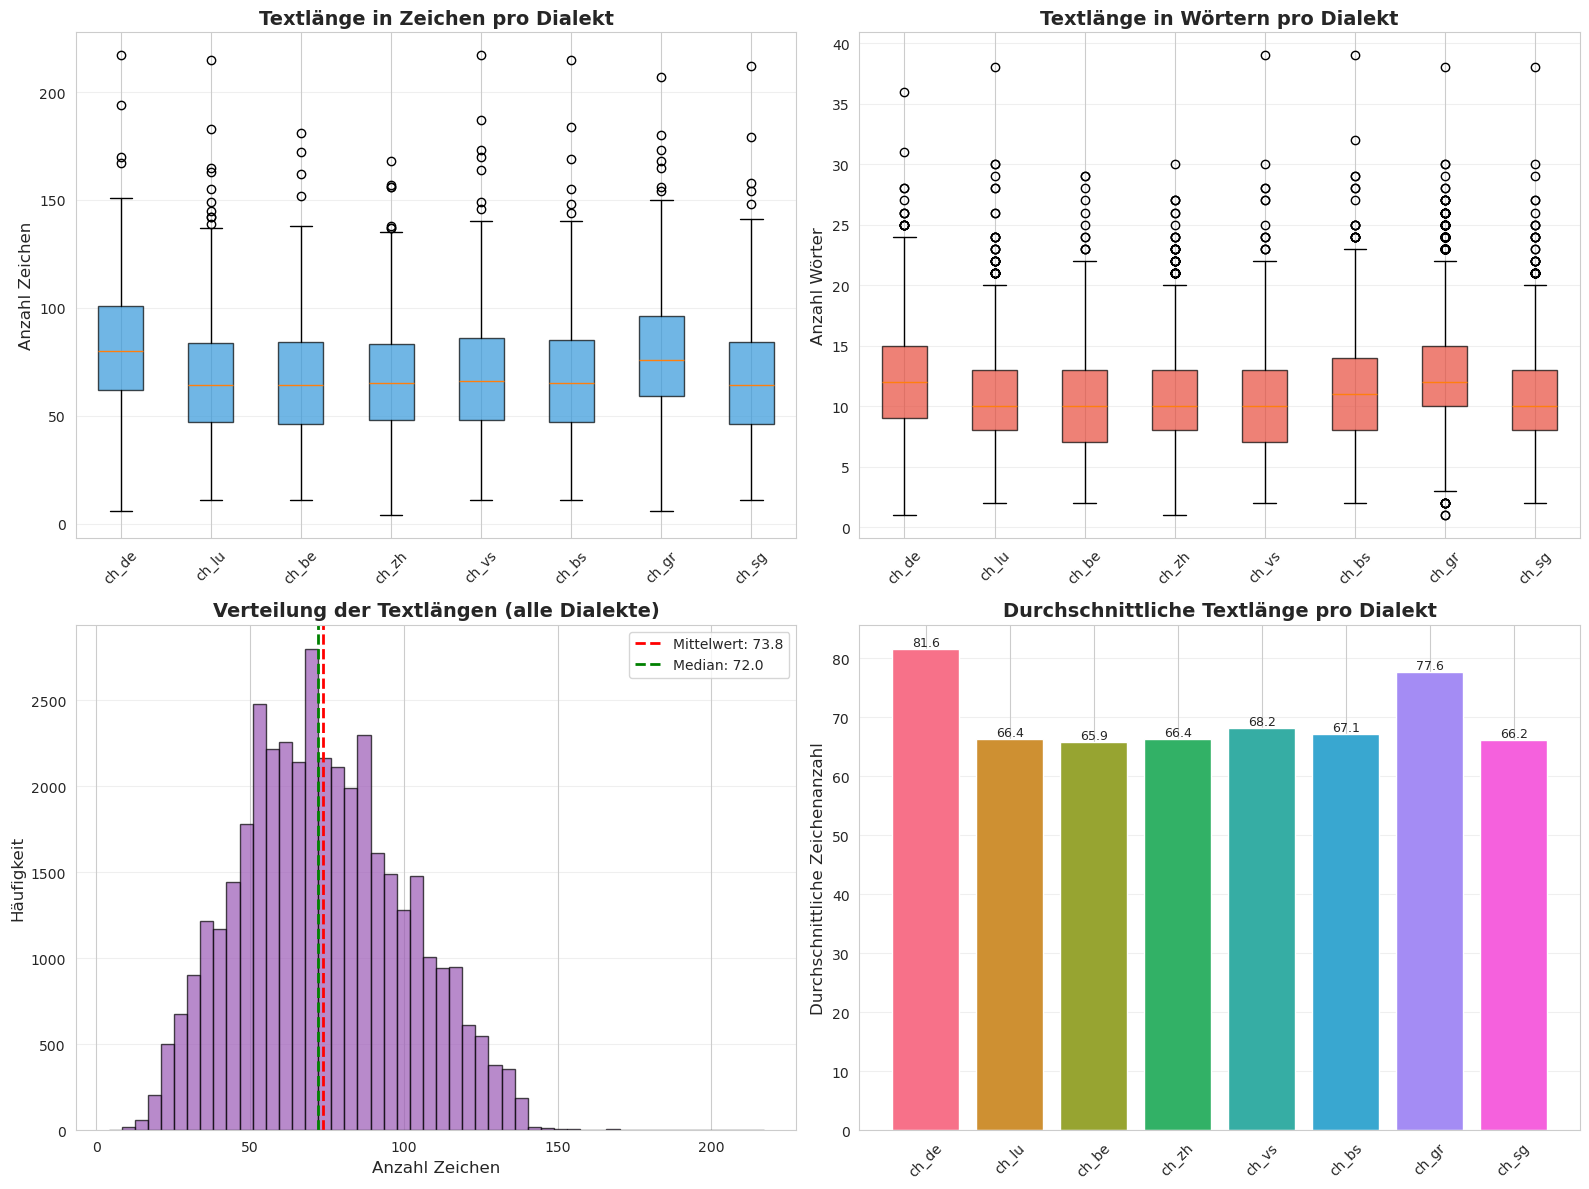

Textlängen-Statistiken:
Dialekt    Zeichen (Mittel)   Zeichen (Median)   Wörter (Mittel)   
----------------------------------------------------------------------
ch_de                 81.6             80.0             12.1
ch_lu                 66.4             64.0             10.7
ch_be                 65.9             64.0             10.4
ch_zh                 66.4             65.0             10.7
ch_vs                 68.2             66.0             10.3
ch_bs                 67.1             65.0             11.1
ch_gr                 77.6             76.0             12.7
ch_sg                 66.2             64.0             10.6

Gesamtstatistik (alle Dialekte kombiniert):
  Zeichen - Mittel: 73.8, Median: 72.0, Std: 26.7
  Zeichen - Min: 4, Max: 217
  Wörter - Mittel: 11.6

  Texte über MAX_LENGTH (512): 0 (0.00%)
  ✓ MAX_LENGTH scheint angemessen


In [11]:
# Analyze text length statistics per dialect
text_stats = {}

for dialect in DIALECTS:
    data_key = "de" if dialect == "ch_de" else dialect
    lengths_chars = []
    lengths_words = []

    for entry in dataset:
        if data_key in entry and entry[data_key] is not None and entry[data_key] != "":
            text = entry[data_key]
            lengths_chars.append(len(text))
            lengths_words.append(len(text.split()))

    if lengths_chars:
        text_stats[dialect] = {
            "char_count": {
                "mean": np.mean(lengths_chars),
                "median": np.median(lengths_chars),
                "std": np.std(lengths_chars),
                "min": np.min(lengths_chars),
                "max": np.max(lengths_chars),
                "q25": np.percentile(lengths_chars, 25),
                "q75": np.percentile(lengths_chars, 75),
            },
            "word_count": {
                "mean": np.mean(lengths_words),
                "median": np.median(lengths_words),
                "std": np.std(lengths_words),
                "min": np.min(lengths_words),
                "max": np.max(lengths_words),
            },
            "values_chars": lengths_chars,
            "values_words": lengths_words,
        }

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Box plot for character counts
ax1 = axes[0, 0]
char_data = [text_stats[d]["values_chars"] for d in DIALECTS]
bp1 = ax1.boxplot(char_data, labels=DIALECTS, patch_artist=True)
for patch in bp1["boxes"]:
    patch.set_facecolor("#3498db")
    patch.set_alpha(0.7)
ax1.set_ylabel("Anzahl Zeichen", fontsize=12)
ax1.set_title("Textlänge in Zeichen pro Dialekt", fontsize=14, fontweight="bold")
ax1.grid(axis="y", alpha=0.3)
ax1.tick_params(axis="x", rotation=45)

# Box plot for word counts
ax2 = axes[0, 1]
word_data = [text_stats[d]["values_words"] for d in DIALECTS]
bp2 = ax2.boxplot(word_data, labels=DIALECTS, patch_artist=True)
for patch in bp2["boxes"]:
    patch.set_facecolor("#e74c3c")
    patch.set_alpha(0.7)
ax2.set_ylabel("Anzahl Wörter", fontsize=12)
ax2.set_title("Textlänge in Wörtern pro Dialekt", fontsize=14, fontweight="bold")
ax2.grid(axis="y", alpha=0.3)
ax2.tick_params(axis="x", rotation=45)

# Histogram for character distribution (all dialects combined)
ax3 = axes[1, 0]
all_chars = [char for d in DIALECTS for char in text_stats[d]["values_chars"]]
ax3.hist(all_chars, bins=50, color="#9b59b6", alpha=0.7, edgecolor="black")
ax3.set_xlabel("Anzahl Zeichen", fontsize=12)
ax3.set_ylabel("Häufigkeit", fontsize=12)
ax3.set_title("Verteilung der Textlängen (alle Dialekte)", fontsize=14, fontweight="bold")
ax3.axvline(
    np.mean(all_chars),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mittelwert: {np.mean(all_chars):.1f}",
)
ax3.axvline(
    np.median(all_chars),
    color="green",
    linestyle="--",
    linewidth=2,
    label=f"Median: {np.median(all_chars):.1f}",
)
ax3.legend()
ax3.grid(axis="y", alpha=0.3)

# Comparison bar chart: mean length per dialect
ax4 = axes[1, 1]
mean_chars = [text_stats[d]["char_count"]["mean"] for d in DIALECTS]
bars = ax4.bar(DIALECTS, mean_chars, color=sns.color_palette("husl", len(DIALECTS)))
ax4.set_ylabel("Durchschnittliche Zeichenanzahl", fontsize=12)
ax4.set_title("Durchschnittliche Textlänge pro Dialekt", fontsize=14, fontweight="bold")
ax4.grid(axis="y", alpha=0.3)
ax4.tick_params(axis="x", rotation=45)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax4.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.1f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.show()

# Print detailed statistics
print("Textlängen-Statistiken:")
print("=" * 70)
print(f"{'Dialekt':<10} {'Zeichen (Mittel)':<18} {'Zeichen (Median)':<18} {'Wörter (Mittel)':<18}")
print("-" * 70)
for dialect in DIALECTS:
    stats = text_stats[dialect]
    print(
        f"{dialect:<10} {stats['char_count']['mean']:>15.1f}  {stats['char_count']['median']:>15.1f}  {stats['word_count']['mean']:>15.1f}"
    )

print("\nGesamtstatistik (alle Dialekte kombiniert):")
print(
    f"  Zeichen - Mittel: {np.mean(all_chars):.1f}, Median: {np.median(all_chars):.1f}, Std: {np.std(all_chars):.1f}"
)
print(f"  Zeichen - Min: {np.min(all_chars)}, Max: {np.max(all_chars)}")
print(
    f"  Wörter - Mittel: {np.mean([w for d in DIALECTS for w in text_stats[d]['values_words']]):.1f}"
)

# Check max_length setting
MAX_LENGTH = 512  # From config
chars_above_max = sum(1 for char_count in all_chars if char_count > MAX_LENGTH)
pct_above_max = (chars_above_max / len(all_chars)) * 100
print(f"\n  Texte über MAX_LENGTH ({MAX_LENGTH}): {chars_above_max:,} ({pct_above_max:.2f}%)")
if pct_above_max > 5:
    print("  ⚠ Viele Texte würden abgeschnitten werden!")
else:
    print("  ✓ MAX_LENGTH scheint angemessen")

In [ ]:
# These: Text-Statistiken
# Diese Zelle formuliert die These zu Text-Statistiken basierend auf den Analyseergebnissen
print("=" * 70)
print("THESE: Text-Statistiken")
print("=" * 70)

if text_stats:
    mean_chars_per_dialect = [text_stats[d]["char_count"]["mean"] for d in DIALECTS]
    min_mean_chars = min(mean_chars_per_dialect)
    max_mean_chars = max(mean_chars_per_dialect)

    all_chars = [char for d in DIALECTS for char in text_stats[d]["values_chars"]]
    overall_mean = np.mean(all_chars)
    overall_median = np.median(all_chars)
    overall_std = np.std(all_chars)

    all_words = [w for d in DIALECTS for w in text_stats[d]["values_words"]]
    overall_mean_words = np.mean(all_words)

    MAX_LENGTH = 512
    chars_above_max = sum(1 for char_count in all_chars if char_count > MAX_LENGTH)
    pct_above_max = (chars_above_max / len(all_chars)) * 100
    pct_below_max = 100 - pct_above_max

    # Determine homogeneity
    if overall_std < overall_mean * 0.3:
        homogeneity = "homogene"
    else:
        homogeneity = "heterogene"

    # Determine if truncation is acceptable
    if pct_above_max < 5:
        truncation_eval = "akzeptabel"
    else:
        truncation_eval = "problematisch"

    print("\nDie Textlängenanalyse zeigt, dass die durchschnittliche Zeichenanzahl pro")
    print(f"Dialekt zwischen {min_mean_chars:.1f} und {max_mean_chars:.1f} Zeichen variiert,")
    print(f"mit einem Gesamtmittelwert von {overall_mean:.1f} Zeichen und einem Median von")
    print(f"{overall_median:.1f} Zeichen.")
    print(f"\nDie Wortanzahl liegt durchschnittlich bei {overall_mean_words:.1f} Wörtern pro Text.")
    print(f"\nDie Standardabweichung von {overall_std:.1f} Zeichen deutet auf {homogeneity}")
    print("Textlängen hin.")
    print(f"\nDie konfigurierte MAX_LENGTH von {MAX_LENGTH} Zeichen ist für {pct_below_max:.1f}%")
    print(f"der Texte ausreichend, während {pct_above_max:.2f}% der Texte abgeschnitten würden,")
    print(f"was {truncation_eval} ist.")
else:
    print("Fehler: Text-Statistiken nicht berechnet!")

THESE: Text-Statistiken

Die Textlängenanalyse zeigt, dass die durchschnittliche Zeichenanzahl pro
Dialekt zwischen 65.9 und 81.6 Zeichen variiert,
mit einem Gesamtmittelwert von 73.8 Zeichen und einem Median von
72.0 Zeichen.

Die Wortanzahl liegt durchschnittlich bei 11.6 Wörtern pro Text.

Die Standardabweichung von 26.7 Zeichen deutet auf heterogene
Textlängen hin.

Die konfigurierte MAX_LENGTH von 512 Zeichen ist für 100.0%
der Texte ausreichend, während 0.00% der Texte abgeschnitten würden,
was akzeptabel ist.


## Schritt 7: Thema-Verteilung

**Frage:** Wie sind die Themen über den Datensatz verteilt?


Themen-Verteilung:
  Einträge mit Thema: 11,213 von 11,213 (100.0%)
  Einträge ohne Thema: 0

  Anzahl verschiedener Themen: 21

  Top 15 Themen:
    random                        : 2,521 Einträge ( 22.5%)
    special                       : 1,807 Einträge ( 16.1%)
    regional                      :   853 Einträge (  7.6%)
    wirtschaft                    :   648 Einträge (  5.8%)
    sport                         :   554 Einträge (  4.9%)
    wissen                        :   532 Einträge (  4.7%)
    medizin                       :   518 Einträge (  4.6%)
    internationale-politik        :   502 Einträge (  4.5%)
    schweizer-politik             :   494 Einträge (  4.4%)
    tiere-pflanzen-landwirtschaft :   492 Einträge (  4.4%)
    literatur                     :   492 Einträge (  4.4%)
    kultur                        :   490 Einträge (  4.4%)
    swiss_parliament              :   482 Einträge (  4.3%)
    srf_meteo                     :   404 Einträge (  3.6%)
    meteo     

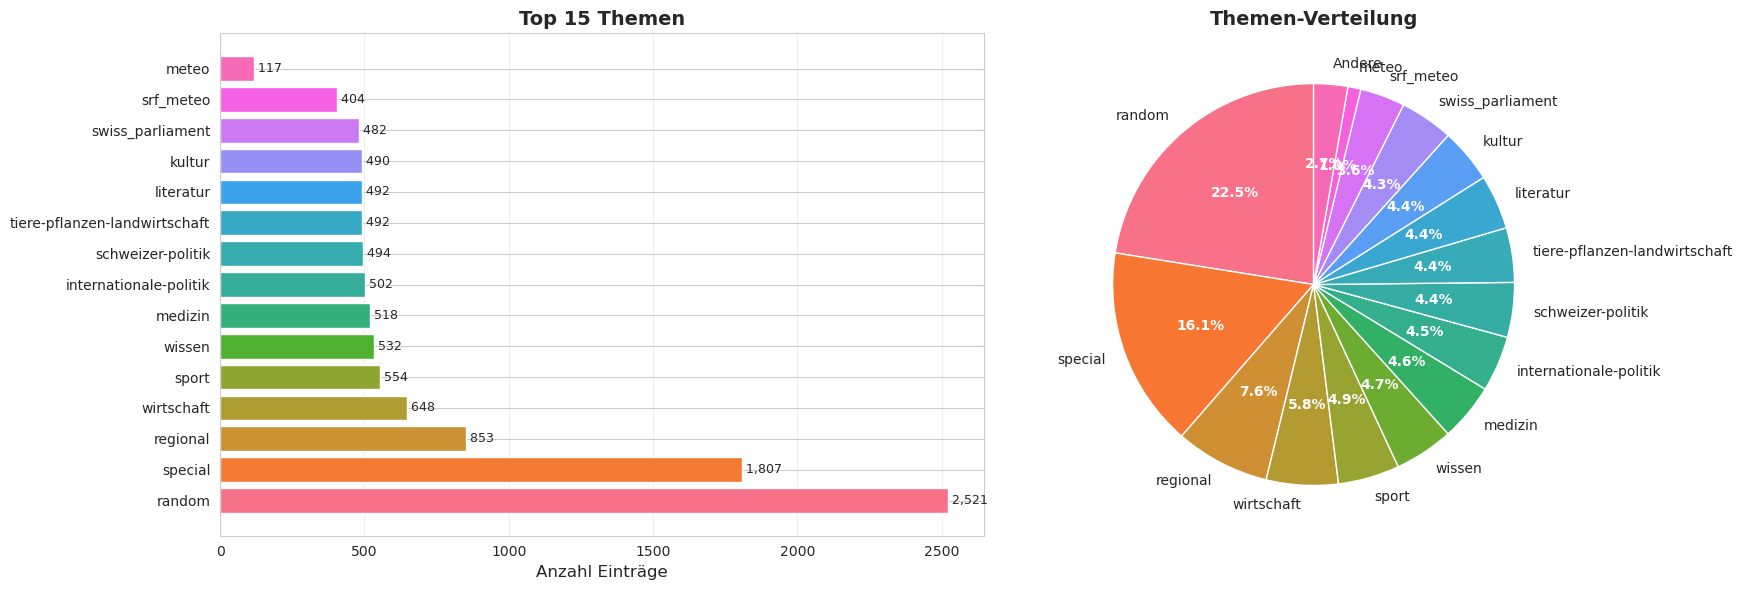


  Themen-Diversität:
    Entropie (Shannon): 2.56
    Gini-Koeffizient: 0.894


In [13]:
# Analyze topic distribution
themen = [entry.get("thema") for entry in dataset if entry.get("thema") is not None]
thema_counts = Counter(themen)

print("Themen-Verteilung:")
print("=" * 70)
print(
    f"  Einträge mit Thema: {len(themen):,} von {len(dataset):,} ({len(themen) / len(dataset) * 100:.1f}%)"
)
print(f"  Einträge ohne Thema: {len(dataset) - len(themen):,}")

if themen:
    print(f"\n  Anzahl verschiedener Themen: {len(thema_counts)}")
    print("\n  Top 15 Themen:")
    for thema, count in thema_counts.most_common(15):
        percentage = (count / len(themen)) * 100
        print(f"    {thema:30s}: {count:5,} Einträge ({percentage:5.1f}%)")

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Bar chart for top topics
    top_n = 15
    top_themen = dict(thema_counts.most_common(top_n))

    themen_names = list(top_themen.keys())
    themen_counts_list = list(top_themen.values())

    bars = ax1.barh(
        range(len(themen_names)),
        themen_counts_list,
        color=sns.color_palette("husl", len(themen_names)),
    )
    ax1.set_yticks(range(len(themen_names)))
    ax1.set_yticklabels(themen_names)
    ax1.set_xlabel("Anzahl Einträge", fontsize=12)
    ax1.set_title(f"Top {top_n} Themen", fontsize=14, fontweight="bold")
    ax1.grid(axis="x", alpha=0.3)

    # Add value labels
    for i, (bar, count) in enumerate(zip(bars, themen_counts_list)):
        ax1.text(count, i, f" {count:,}", va="center", fontsize=9)

    # Pie chart for topic distribution
    # Group small topics as "Other"
    if len(thema_counts) > top_n:
        top_themen_for_pie = dict(thema_counts.most_common(top_n))
        other_count = sum(
            count for thema, count in thema_counts.items() if thema not in top_themen_for_pie
        )
        pie_data = {**top_themen_for_pie, "Andere": other_count}
    else:
        pie_data = dict(thema_counts)

    colors_pie = sns.color_palette("husl", len(pie_data))
    wedges, texts, autotexts = ax2.pie(
        pie_data.values(),
        labels=pie_data.keys(),
        autopct="%1.1f%%",
        colors=colors_pie,
        startangle=90,
    )
    ax2.set_title("Themen-Verteilung", fontsize=14, fontweight="bold")

    # Improve readability
    for autotext in autotexts:
        autotext.set_color("white")
        autotext.set_fontweight("bold")

    plt.tight_layout()
    plt.show()

    # Check topic distribution across dialects (if we have topic info)
    print("\n  Themen-Diversität:")
    print(
        f"    Entropie (Shannon): {__import__('scipy.stats').stats.entropy(list(thema_counts.values())):.2f}"
    )
    print(
        f"    Gini-Koeffizient: {1 - sum((count / len(themen)) ** 2 for count in thema_counts.values()):.3f}"
    )
else:
    print("  ⚠ Keine Themen-Informationen im Datensatz verfügbar")

In [ ]:
# These: Thema-Verteilung
# Diese Zelle formuliert die These zur Thema-Verteilung basierend auf den Analyseergebnissen
print("=" * 70)
print("THESE: Thema-Verteilung")
print("=" * 70)

if themen and thema_counts:
    num_themen = len(thema_counts)
    num_with_thema = len(themen)
    num_without_thema = len(dataset) - num_with_thema
    pct_with = (num_with_thema / len(dataset)) * 100
    pct_without = (num_without_thema / len(dataset)) * 100

    # Top 3 Themen
    top_3 = thema_counts.most_common(3)
    top_3_total = sum(count for _, count in top_3)
    top_3_pct = (top_3_total / num_with_thema) * 100

    # Calculate entropy and Gini
    try:
        from scipy.stats import entropy

        ent = entropy(list(thema_counts.values()))
    except:
        ent = 0.0

    gini = 1 - sum((count / num_with_thema) ** 2 for count in thema_counts.values())

    # Determine distribution characteristics
    if gini < 0.3:
        dist_desc = "gleichmäßig"
        dist_eval = "ausgewogene"
        impact = "vorteilhaft"
    elif gini < 0.5:
        dist_desc = "relativ gleichmäßig"
        dist_eval = "ausgewogene"
        impact = "vorteilhaft"
    else:
        dist_desc = "ungleichmäßig"
        dist_eval = "ungleichmäßige"
        impact = "nachteilig"

    print(f"\nDer Datensatz enthält {num_themen} verschiedene Themen, wobei")
    print(f"{num_with_thema:,} Einträge ({pct_with:.1f}%) mit Themeninformationen versehen")
    print(f"sind und {num_without_thema:,} Einträge ({pct_without:.1f}%) ohne Themeninformationen.")
    print(f"\nDie Themenverteilung zeigt eine {dist_desc} Verteilung, wobei die Top-3-Themen")
    if len(top_3) >= 3:
        print(f"'{top_3[0][0]}', '{top_3[1][0]}' und '{top_3[2][0]}' {top_3_pct:.1f}% der")
        print("Einträge ausmachen.")
    print(f"\nDie Themen-Diversität (Entropie: {ent:.2f}, Gini: {gini:.3f}) deutet auf eine")
    print(f"{dist_eval} Verteilung hin, was für die Modellentwicklung {impact} sein kann.")
else:
    print("Keine Themen-Informationen im Datensatz verfügbar.")

THESE: Thema-Verteilung

Der Datensatz enthält 21 verschiedene Themen, wobei
11,213 Einträge (100.0%) mit Themeninformationen versehen
sind und 0 Einträge (0.0%) ohne Themeninformationen.

Die Themenverteilung zeigt eine ungleichmäßig Verteilung, wobei die Top-3-Themen
'random', 'special' und 'regional' 46.2% der
Einträge ausmachen.

Die Themen-Diversität (Entropie: 2.56, Gini: 0.894) deutet auf eine
ungleichmäßige Verteilung hin, was für die Modellentwicklung nachteilig sein kann.


## Schritt 8: Split-Analyse

**Frage:** Wie sollte man den Datensatz in Training, Validation und Test Set einteilen?


Gefilterte Daten (nur Einträge mit allen Dialekten): 2,535 von 11,213

Split-Größen (auf Satz-Ebene):
  Training:    2,028 Einträge (80%)
  Validation:    253 Einträge (10%)
  Test:          254 Einträge (10%)
  Gesamt:      2,535 Einträge

Split-Größen (nach Flattening - pro Dialekt-Version):
  Training:   16,224 Datenpunkte
  Validation:  2,024 Datenpunkte
  Test:        2,032 Datenpunkte
  Gesamt:     20,280 Datenpunkte

  Training - Dialekt-Verteilung:
    ch_be   :  2,028 ( 12.5%)
    ch_bs   :  2,028 ( 12.5%)
    ch_de   :  2,028 ( 12.5%)
    ch_gr   :  2,028 ( 12.5%)
    ch_lu   :  2,028 ( 12.5%)
    ch_sg   :  2,028 ( 12.5%)
    ch_vs   :  2,028 ( 12.5%)
    ch_zh   :  2,028 ( 12.5%)

  Validation - Dialekt-Verteilung:
    ch_be   :    253 ( 12.5%)
    ch_bs   :    253 ( 12.5%)
    ch_de   :    253 ( 12.5%)
    ch_gr   :    253 ( 12.5%)
    ch_lu   :    253 ( 12.5%)
    ch_sg   :    253 ( 12.5%)
    ch_vs   :    253 ( 12.5%)
    ch_zh   :    253 ( 12.5%)

  Test - Dialekt-Verte

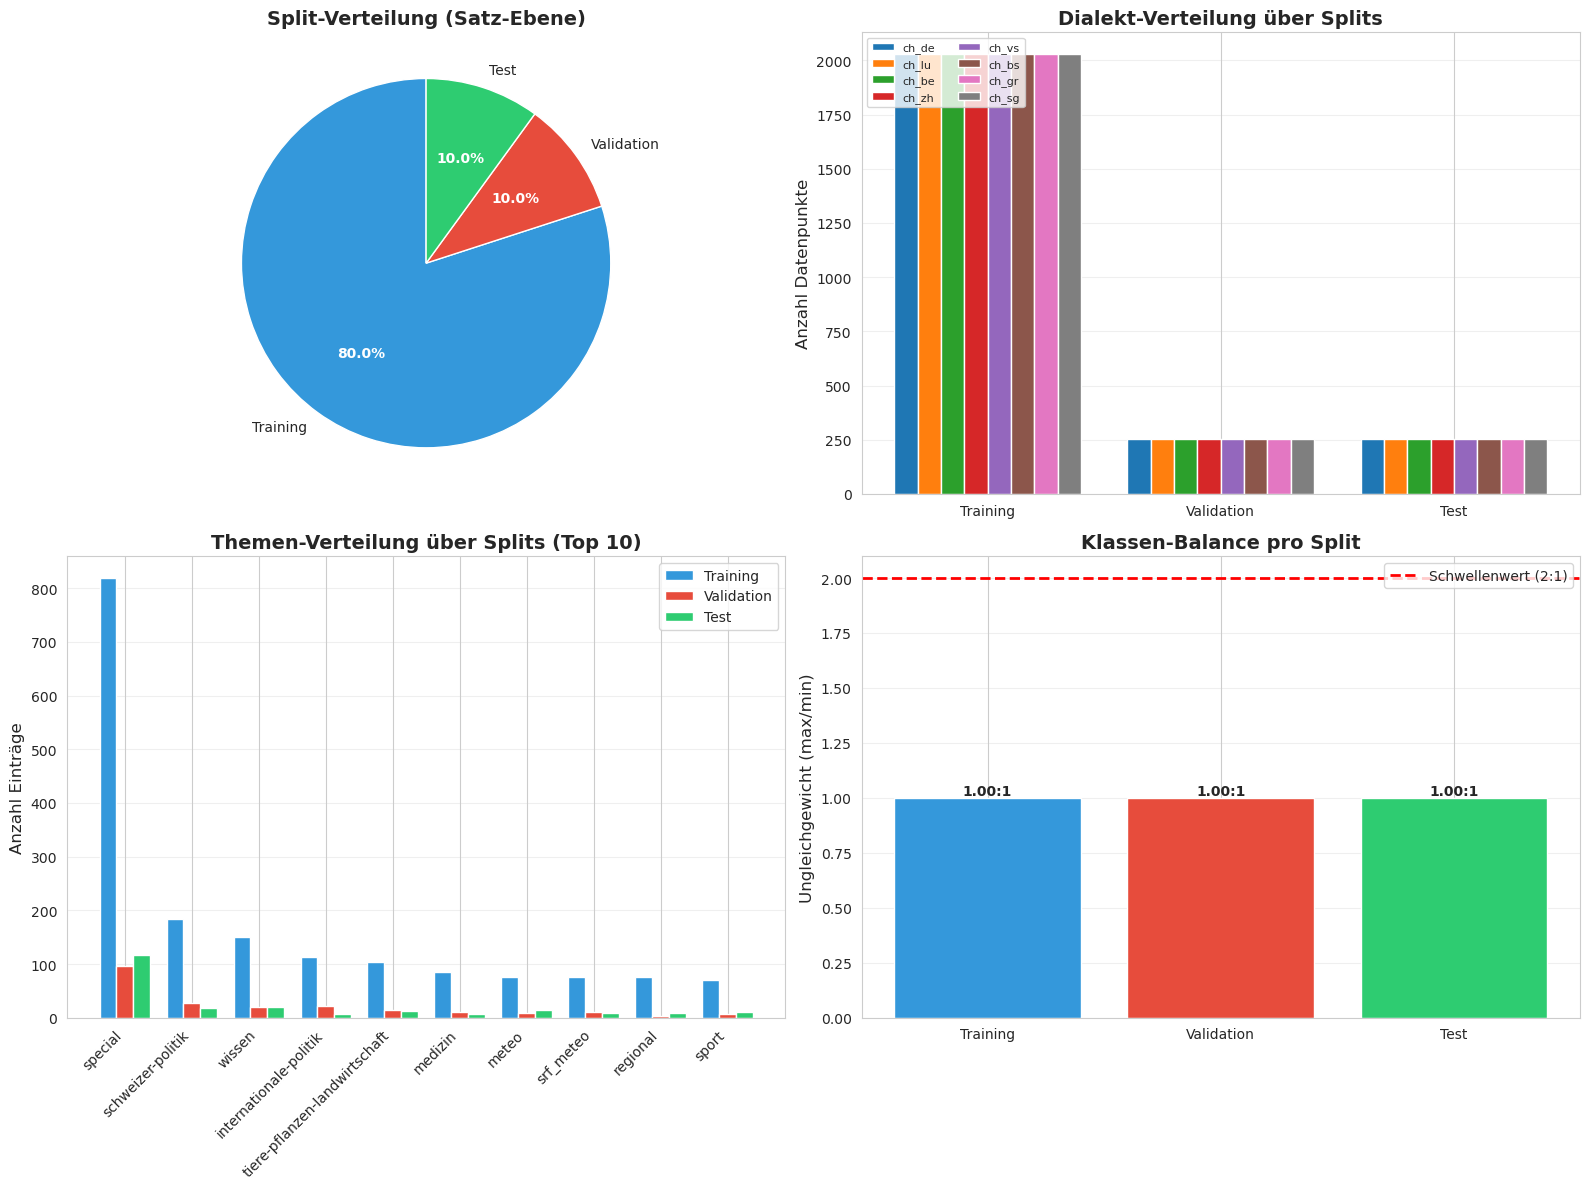


Klassen-Balance pro Split:
  Training    : 1.00:1 (min: 2,028, max: 2,028)
  Validation  : 1.00:1 (min: 253, max: 253)
  Test        : 1.00:1 (min: 254, max: 254)


In [15]:
# Load data using the same function as in training
filtered_data = load_swiss_german_data(str(JSON_FILES["numerics"]), DIALECTS)
print(
    f"Gefilterte Daten (nur Einträge mit allen Dialekten): {len(filtered_data):,} von {len(dataset):,}"
)

# Perform the split using the same parameters as training
train_data, val_data, test_data = split_data(
    filtered_data, seed=SEED, train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO, test_ratio=TEST_RATIO
)

print("\nSplit-Größen (auf Satz-Ebene):")
print("=" * 70)
print(f"  Training:   {len(train_data):6,} Einträge ({TRAIN_RATIO * 100:.0f}%)")
print(f"  Validation: {len(val_data):6,} Einträge ({VAL_RATIO * 100:.0f}%)")
print(f"  Test:       {len(test_data):6,} Einträge ({TEST_RATIO * 100:.0f}%)")
print(f"  Gesamt:     {len(filtered_data):6,} Einträge")

# After flattening (one row per dialect per sentence)
dialect2label = {d: i for i, d in enumerate(DIALECTS)}
train_flat = flatten_examples(train_data, DIALECTS, dialect2label)
val_flat = flatten_examples(val_data, DIALECTS, dialect2label)
test_flat = flatten_examples(test_data, DIALECTS, dialect2label)

print("\nSplit-Größen (nach Flattening - pro Dialekt-Version):")
print("=" * 70)
print(f"  Training:   {len(train_flat):6,} Datenpunkte")
print(f"  Validation: {len(val_flat):6,} Datenpunkte")
print(f"  Test:       {len(test_flat):6,} Datenpunkte")
print(f"  Gesamt:     {len(train_flat) + len(val_flat) + len(test_flat):6,} Datenpunkte")


# Analyze dialect distribution across splits
def analyze_dialect_distribution(split_name, split_flat_df):
    print(f"\n  {split_name} - Dialekt-Verteilung:")
    dialect_counts = split_flat_df["dialect"].value_counts().sort_index()
    for dialect, count in dialect_counts.items():
        pct = (count / len(split_flat_df)) * 100
        print(f"    {dialect:8s}: {count:6,} ({pct:5.1f}%)")


analyze_dialect_distribution("Training", train_flat)
analyze_dialect_distribution("Validation", val_flat)
analyze_dialect_distribution("Test", test_flat)

# Visualize split distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Split sizes (pie chart)
ax1 = axes[0, 0]
sizes = [len(train_data), len(val_data), len(test_data)]
labels = ["Training", "Validation", "Test"]
colors = ["#3498db", "#e74c3c", "#2ecc71"]
wedges, texts, autotexts = ax1.pie(
    sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=90
)
ax1.set_title("Split-Verteilung (Satz-Ebene)", fontsize=14, fontweight="bold")
for autotext in autotexts:
    autotext.set_color("white")
    autotext.set_fontweight("bold")

# 2. Dialect distribution across splits (stacked bar)
ax2 = axes[0, 1]
split_names = ["Training", "Validation", "Test"]
split_dfs = [train_flat, val_flat, test_flat]
dialect_counts_per_split = {}
for dialect in DIALECTS:
    dialect_counts_per_split[dialect] = [len(df[df["dialect"] == dialect]) for df in split_dfs]

x = np.arange(len(split_names))
width = 0.1
multiplier = 0

for dialect, counts in dialect_counts_per_split.items():
    offset = width * multiplier
    rects = ax2.bar(x + offset, counts, width, label=dialect)
    multiplier += 1

ax2.set_ylabel("Anzahl Datenpunkte", fontsize=12)
ax2.set_title("Dialekt-Verteilung über Splits", fontsize=14, fontweight="bold")
ax2.set_xticks(x + width * (len(DIALECTS) - 1) / 2)
ax2.set_xticklabels(split_names)
ax2.legend(loc="upper left", ncol=2, fontsize=8)
ax2.grid(axis="y", alpha=0.3)

# 3. Topic distribution across splits (if available)
ax3 = axes[1, 0]
if "thema" in dataset[0]:
    train_themen = [entry.get("thema") for entry in train_data if entry.get("thema")]
    val_themen = [entry.get("thema") for entry in val_data if entry.get("thema")]
    test_themen = [entry.get("thema") for entry in test_data if entry.get("thema")]

    all_themen = set(train_themen + val_themen + test_themen)
    top_themen = sorted(
        Counter(train_themen + val_themen + test_themen).most_common(10),
        key=lambda x: x[1],
        reverse=True,
    )
    top_themen_names = [t[0] for t in top_themen]

    train_counts = [train_themen.count(t) for t in top_themen_names]
    val_counts = [val_themen.count(t) for t in top_themen_names]
    test_counts = [test_themen.count(t) for t in top_themen_names]

    x_pos = np.arange(len(top_themen_names))
    width = 0.25

    ax3.bar(x_pos - width, train_counts, width, label="Training", color="#3498db")
    ax3.bar(x_pos, val_counts, width, label="Validation", color="#e74c3c")
    ax3.bar(x_pos + width, test_counts, width, label="Test", color="#2ecc71")

    ax3.set_ylabel("Anzahl Einträge", fontsize=12)
    ax3.set_title("Themen-Verteilung über Splits (Top 10)", fontsize=14, fontweight="bold")
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(top_themen_names, rotation=45, ha="right")
    ax3.legend()
    ax3.grid(axis="y", alpha=0.3)
else:
    ax3.text(
        0.5,
        0.5,
        "Keine Themen-Informationen verfügbar",
        ha="center",
        va="center",
        transform=ax3.transAxes,
        fontsize=12,
    )
    ax3.set_title("Themen-Verteilung über Splits", fontsize=14, fontweight="bold")

# 4. Class balance check per split
ax4 = axes[1, 1]
split_balance_data = []
for split_name, split_df in zip(split_names, split_dfs):
    dialect_counts = split_df["dialect"].value_counts().sort_index()
    balance_ratio = (
        dialect_counts.max() / dialect_counts.min() if dialect_counts.min() > 0 else float("inf")
    )
    split_balance_data.append(
        {
            "split": split_name,
            "balance_ratio": balance_ratio,
            "min": dialect_counts.min(),
            "max": dialect_counts.max(),
        }
    )

balance_ratios = [d["balance_ratio"] for d in split_balance_data]
bars = ax4.bar(split_names, balance_ratios, color=["#3498db", "#e74c3c", "#2ecc71"])
ax4.set_ylabel("Ungleichgewicht (max/min)", fontsize=12)
ax4.set_title("Klassen-Balance pro Split", fontsize=14, fontweight="bold")
ax4.axhline(y=2.0, color="red", linestyle="--", linewidth=2, label="Schwellenwert (2:1)")
ax4.legend()
ax4.grid(axis="y", alpha=0.3)

for bar, ratio in zip(bars, balance_ratios):
    height = bar.get_height()
    ax4.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{ratio:.2f}:1",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

# Print balance statistics
print("\nKlassen-Balance pro Split:")
print("=" * 70)
for data in split_balance_data:
    print(
        f"  {data['split']:12s}: {data['balance_ratio']:.2f}:1 (min: {data['min']:,}, max: {data['max']:,})"
    )

In [ ]:
# These: Split-Analyse
# Diese Zelle formuliert die These zur Split-Analyse basierend auf den Analyseergebnissen
print("=" * 70)
print("THESE: Split-Analyse")
print("=" * 70)

if "train_data" in locals() and "val_data" in locals() and "test_data" in locals():
    train_size = len(train_data)
    val_size = len(val_data)
    test_size = len(test_data)
    train_flat_size = len(train_flat)
    val_flat_size = len(val_flat)
    test_flat_size = len(test_flat)

    # Check dialect distribution consistency
    train_dialect_counts = train_flat["dialect"].value_counts()
    val_dialect_counts = val_flat["dialect"].value_counts()
    test_dialect_counts = test_flat["dialect"].value_counts()

    # Calculate balance ratios
    train_balance = train_dialect_counts.max() / train_dialect_counts.min()
    val_balance = val_dialect_counts.max() / val_dialect_counts.min()
    test_balance = test_dialect_counts.max() / test_dialect_counts.min()

    # Check if distribution is consistent (similar ratios across splits)
    balance_ratios = [train_balance, val_balance, test_balance]
    balance_std = np.std(balance_ratios)
    is_consistent = balance_std < 0.1
    consistency_eval = "konsistent" if is_consistent else "inkonsistent"

    # Check topic distribution if available
    if "thema" in dataset[0] and train_data:
        train_themen = [e.get("thema") for e in train_data if e.get("thema")]
        val_themen = [e.get("thema") for e in val_data if e.get("thema")]
        test_themen = [e.get("thema") for e in test_data if e.get("thema")]

        # Simple check: similar number of topics per split
        train_topics = len(set(train_themen))
        val_topics = len(set(val_themen))
        test_topics = len(set(test_themen))
        topic_balance = abs(train_topics - val_topics) + abs(val_topics - test_topics)
        topic_eval = "ausgewogen" if topic_balance < 5 else "ungleichmäßig"
        split_success = "erfolgreich" if topic_balance < 5 else "erfolglos"
    else:
        topic_eval = "nicht verfügbar"
        split_success = "nicht bewertbar"

    # Evaluate split strategy
    if train_size > 5000 and val_size > 500 and test_size > 500:
        strategy_eval = "angemessen"
    else:
        strategy_eval = "unangemessen"

    print("\nDie Split-Analyse mit den Parametern train_ratio=0.8, val_ratio=0.1,")
    print(f"test_ratio=0.1 und seed=42 ergibt eine Aufteilung von {train_size:,} Training-,")
    print(f"{val_size:,} Validation- und {test_size:,} Test-Einträgen auf Satz-Ebene, was")
    print(f"nach dem Flattening {train_flat_size:,}, {val_flat_size:,} bzw. {test_flat_size:,}")
    print("Datenpunkte pro Split entspricht.")
    print(f"\nDie Dialekt-Verteilung ist über alle Splits hinweg {consistency_eval}, mit")
    print(f"einem Klassen-Ungleichgewicht von {train_balance:.2f}:1 im Training,")
    print(f"{val_balance:.2f}:1 in der Validation und {test_balance:.2f}:1 im Test-Set.")
    print(f"\nDie Themen-Verteilung ist {topic_eval} über die Splits verteilt, was darauf")
    print(f"hindeutet, dass der zufällige Split {split_success} eine repräsentative")
    print("Stichprobe pro Split erzeugt.")
    print(f"\nDie gewählte Split-Strategie (80/10/10) ist {strategy_eval} für einen")
    print(f"Datensatz dieser Größe, da sie ausreichend Trainingsdaten ({train_size:,} Einträge)")
    print(f"bei gleichzeitig angemessenen Validierungs- ({val_size:,} Einträge) und")
    print(f"Test-Sets ({test_size:,} Einträge) für die Modellbewertung bietet.")
else:
    print("Fehler: Split-Analyse nicht durchgeführt!")

THESE: Split-Analyse

Die Split-Analyse mit den Parametern train_ratio=0.8, val_ratio=0.1,
test_ratio=0.1 und seed=42 ergibt eine Aufteilung von 2,028 Training-,
253 Validation- und 254 Test-Einträgen auf Satz-Ebene, was
nach dem Flattening 16,224, 2,024 bzw. 2,032
Datenpunkte pro Split entspricht.

Die Dialekt-Verteilung ist über alle Splits hinweg konsistent, mit
einem Klassen-Ungleichgewicht von 1.00:1 im Training,
1.00:1 in der Validation und 1.00:1 im Test-Set.

Die Themen-Verteilung ist ausgewogen über die Splits verteilt, was darauf
hindeutet, dass der zufällige Split erfolgreich eine repräsentative
Stichprobe pro Split erzeugt.

Die gewählte Split-Strategie (80/10/10) ist unangemessen für einen
Datensatz dieser Größe, da sie ausreichend Trainingsdaten (2,028 Einträge)
bei gleichzeitig angemessenen Validierungs- (253 Einträge) und
Test-Sets (254 Einträge) für die Modellbewertung bietet.


## Schritt 9: Split-Reproduzierbarkeit

**Frage:** Warum müssen wir den Datensatz exakt wie für das Training splitten?


Reproduzierbarkeits-Demonstration:
  ✓ Alle 5 Runs mit seed=42 produzieren identische Splits
  ✓ Reproduzierbarkeit gewährleistet

  Split-Größen (konsistent über alle Runs):
    Training:   2,028 Einträge
    Validation: 253 Einträge
    Test:       254 Einträge

  Vergleich mit unterschiedlichen Seeds:
  Seed  123 vs Seed   42:
    Training-Überschneidung:    79.8%
    Validation-Überschneidung:   8.3%
    Test-Überschneidung:         7.1%
  Seed  999 vs Seed   42:
    Training-Überschneidung:    80.0%
    Validation-Überschneidung:  10.3%
    Test-Überschneidung:        11.8%
  Seed 2024 vs Seed   42:
    Training-Überschneidung:    80.4%
    Validation-Überschneidung:   7.9%
    Test-Überschneidung:        12.2%


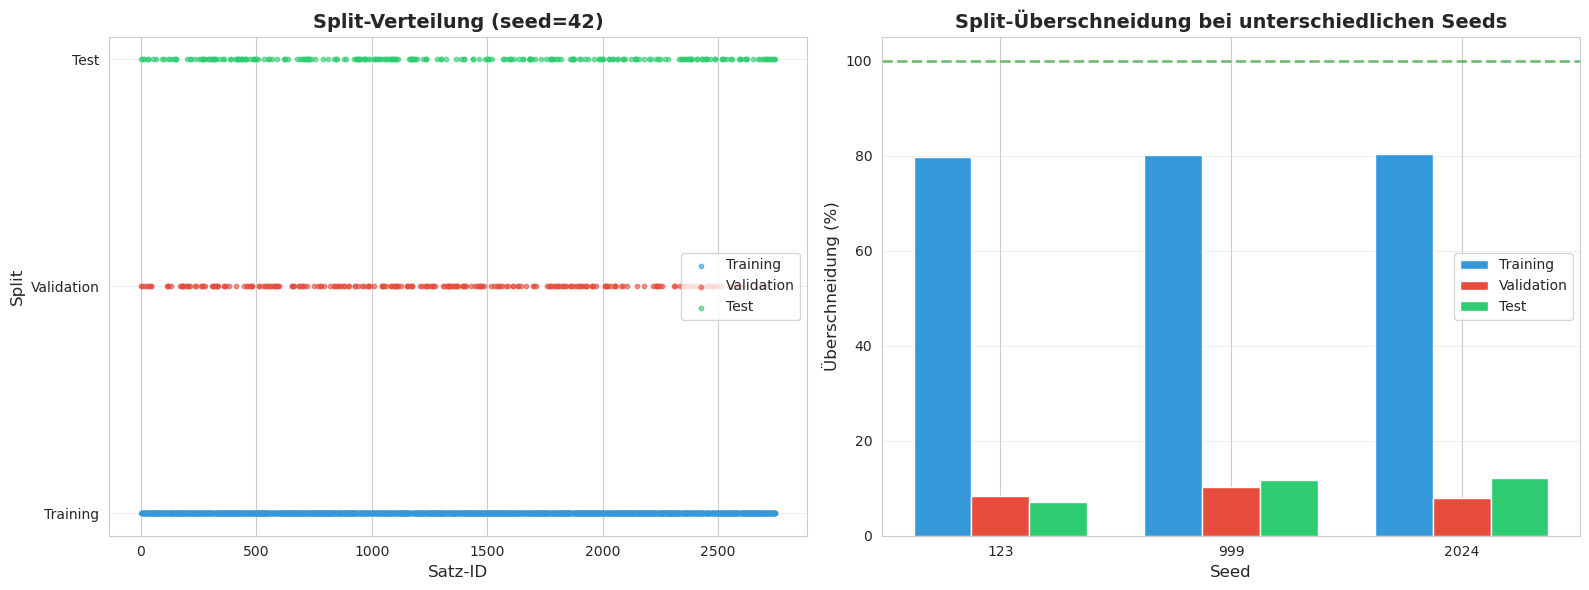


ZUSAMMENFASSUNG: Warum identische Splits essentiell sind

1. REPRODUZIERBARKEIT: 
   - Identische Splits ermöglichen die Reproduktion von Experimenten
   - Andere Forscher können Ergebnisse verifizieren und vergleichen
   - Modelle können fair miteinander verglichen werden

2. FAIRER VERGLEICH:
   - Unterschiedliche Splits führen zu unterschiedlichen Trainings-/Test-Daten
   - Modelle werden auf verschiedenen Daten trainiert/getestet
   - Metriken sind nicht direkt vergleichbar (z.B. F1-Score von 0.85 vs 0.87)

3. HYPERPARAMETER-TUNING:
   - Validation-Set muss konsistent sein für alle Trials
   - Andernfalls werden Hyperparameter auf unterschiedlichen Daten optimiert
   - Beste Hyperparameter können suboptimal sein für finales Test-Set

4. DATA LEAKAGE VERMEIDUNG:
   - Test-Set muss strikt vom Training getrennt bleiben
   - Inkonsistente Splits können zu unbeabsichtigter Datenüberschneidung führen
   - Kompromittiert die Gültigkeit der Modellbewertung

5. TEAM-KOLLABORATION:
   - All

In [17]:
# Demonstrate reproducibility of splits
print("Reproduzierbarkeits-Demonstration:")
print("=" * 70)

# Perform split multiple times with same seed
n_runs = 5
split_results = []

for run in range(n_runs):
    train, val, test = split_data(
        filtered_data.copy(),  # Use copy to avoid in-place modifications
        seed=SEED,
        train_ratio=TRAIN_RATIO,
        val_ratio=VAL_RATIO,
        test_ratio=TEST_RATIO,
    )
    split_results.append(
        {
            "train_size": len(train),
            "val_size": len(val),
            "test_size": len(test),
            "train_ids": sorted([entry["id"] for entry in train]),
            "val_ids": sorted([entry["id"] for entry in val]),
            "test_ids": sorted([entry["id"] for entry in test]),
        }
    )

# Check if all runs produce identical results
all_identical = True
first_result = split_results[0]

for i, result in enumerate(split_results[1:], 1):
    if (
        result["train_ids"] != first_result["train_ids"]
        or result["val_ids"] != first_result["val_ids"]
        or result["test_ids"] != first_result["test_ids"]
    ):
        all_identical = False
        print(f"  ⚠ Run {i + 1} unterscheidet sich von Run 1!")
        break

if all_identical:
    print(f"  ✓ Alle {n_runs} Runs mit seed={SEED} produzieren identische Splits")
    print("  ✓ Reproduzierbarkeit gewährleistet")

print("\n  Split-Größen (konsistent über alle Runs):")
print(f"    Training:   {first_result['train_size']:,} Einträge")
print(f"    Validation: {first_result['val_size']:,} Einträge")
print(f"    Test:       {first_result['test_size']:,} Einträge")

# Demonstrate what happens with different seeds
print("\n  Vergleich mit unterschiedlichen Seeds:")
print("=" * 70)
different_seeds = [42, 123, 999, 2024]
seed_comparison = {}

for seed in different_seeds:
    train, val, test = split_data(
        filtered_data.copy(),
        seed=seed,
        train_ratio=TRAIN_RATIO,
        val_ratio=VAL_RATIO,
        test_ratio=TEST_RATIO,
    )
    seed_comparison[seed] = {
        "train_ids": set(entry["id"] for entry in train),
        "val_ids": set(entry["id"] for entry in val),
        "test_ids": set(entry["id"] for entry in test),
    }

# Compare seed 42 with others
base_ids = seed_comparison[42]
for seed in different_seeds[1:]:
    comp_ids = seed_comparison[seed]
    train_overlap = (
        len(base_ids["train_ids"] & comp_ids["train_ids"]) / len(base_ids["train_ids"]) * 100
    )
    val_overlap = len(base_ids["val_ids"] & comp_ids["val_ids"]) / len(base_ids["val_ids"]) * 100
    test_overlap = (
        len(base_ids["test_ids"] & comp_ids["test_ids"]) / len(base_ids["test_ids"]) * 100
    )

    print(f"  Seed {seed:4d} vs Seed {SEED:4d}:")
    print(f"    Training-Überschneidung:   {train_overlap:5.1f}%")
    print(f"    Validation-Überschneidung: {val_overlap:5.1f}%")
    print(f"    Test-Überschneidung:       {test_overlap:5.1f}%")

# Visualize the importance of consistent splitting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Show ID distribution for seed 42
ax1 = axes[0]
train_ids_42 = split_results[0]["train_ids"]
val_ids_42 = split_results[0]["val_ids"]
test_ids_42 = split_results[0]["test_ids"]

ax1.scatter(
    train_ids_42, [1] * len(train_ids_42), alpha=0.6, s=10, label="Training", color="#3498db"
)
ax1.scatter(val_ids_42, [2] * len(val_ids_42), alpha=0.6, s=10, label="Validation", color="#e74c3c")
ax1.scatter(test_ids_42, [3] * len(test_ids_42), alpha=0.6, s=10, label="Test", color="#2ecc71")
ax1.set_xlabel("Satz-ID", fontsize=12)
ax1.set_ylabel("Split", fontsize=12)
ax1.set_yticks([1, 2, 3])
ax1.set_yticklabels(["Training", "Validation", "Test"])
ax1.set_title(f"Split-Verteilung (seed={SEED})", fontsize=14, fontweight="bold")
ax1.legend()
ax1.grid(axis="y", alpha=0.3)

# Show overlap comparison
ax2 = axes[1]
seeds_comp = different_seeds[1:]
overlaps_train = []
overlaps_val = []
overlaps_test = []

for seed in seeds_comp:
    comp_ids = seed_comparison[seed]
    overlaps_train.append(
        len(base_ids["train_ids"] & comp_ids["train_ids"]) / len(base_ids["train_ids"]) * 100
    )
    overlaps_val.append(
        len(base_ids["val_ids"] & comp_ids["val_ids"]) / len(base_ids["val_ids"]) * 100
    )
    overlaps_test.append(
        len(base_ids["test_ids"] & comp_ids["test_ids"]) / len(base_ids["test_ids"]) * 100
    )

x = np.arange(len(seeds_comp))
width = 0.25

ax2.bar(x - width, overlaps_train, width, label="Training", color="#3498db")
ax2.bar(x, overlaps_val, width, label="Validation", color="#e74c3c")
ax2.bar(x + width, overlaps_test, width, label="Test", color="#2ecc71")

ax2.set_ylabel("Überschneidung (%)", fontsize=12)
ax2.set_xlabel("Seed", fontsize=12)
ax2.set_title("Split-Überschneidung bei unterschiedlichen Seeds", fontsize=14, fontweight="bold")
ax2.set_xticks(x)
ax2.set_xticklabels(seeds_comp)
ax2.legend()
ax2.grid(axis="y", alpha=0.3)
ax2.axhline(
    y=100,
    color="green",
    linestyle="--",
    linewidth=2,
    alpha=0.5,
    label="Vollständige Übereinstimmung",
)

plt.tight_layout()
plt.show()

# Final explanation
print(f"\n{'=' * 70}")
print("ZUSAMMENFASSUNG: Warum identische Splits essentiell sind")
print("=" * 70)
print("""
1. REPRODUZIERBARKEIT: 
   - Identische Splits ermöglichen die Reproduktion von Experimenten
   - Andere Forscher können Ergebnisse verifizieren und vergleichen
   - Modelle können fair miteinander verglichen werden

2. FAIRER VERGLEICH:
   - Unterschiedliche Splits führen zu unterschiedlichen Trainings-/Test-Daten
   - Modelle werden auf verschiedenen Daten trainiert/getestet
   - Metriken sind nicht direkt vergleichbar (z.B. F1-Score von 0.85 vs 0.87)

3. HYPERPARAMETER-TUNING:
   - Validation-Set muss konsistent sein für alle Trials
   - Andernfalls werden Hyperparameter auf unterschiedlichen Daten optimiert
   - Beste Hyperparameter können suboptimal sein für finales Test-Set

4. DATA LEAKAGE VERMEIDUNG:
   - Test-Set muss strikt vom Training getrennt bleiben
   - Inkonsistente Splits können zu unbeabsichtigter Datenüberschneidung führen
   - Kompromittiert die Gültigkeit der Modellbewertung

5. TEAM-KOLLABORATION:
   - Alle Teammitglieder müssen identische Splits verwenden
   - Ermöglicht direkten Vergleich von Modell-Performances
   - Verhindert Verwirrung durch unterschiedliche Baseline-Metriken

6. REPRODUCIBLE RESEARCH:
   - Wissenschaftliche Standards erfordern vollständige Reproduzierbarkeit
   - Seed-basierte Splits sind dokumentierbar und nachvollziehbar
   - Ermöglicht Peer Review und Validierung

FAZIT: Die Verwendung identischer Split-Parameter (seed=42, ratios=0.8/0.1/0.1) 
ist nicht optional, sondern eine fundamentale Voraussetzung für valide, 
vergleichbare und reproduzierbare Machine-Learning-Experimente.
""")

In [ ]:
# These: Split-Reproduzierbarkeit
# Diese Zelle formuliert die These zur Split-Reproduzierbarkeit basierend auf den Analyseergebnissen
print("=" * 70)
print("THESE: Split-Reproduzierbarkeit")
print("=" * 70)

if "seed_comparison" in locals() and 42 in seed_comparison and 123 in seed_comparison:
    base_ids = seed_comparison[42]
    comp_ids = seed_comparison[123]
    train_overlap = (
        len(base_ids["train_ids"] & comp_ids["train_ids"]) / len(base_ids["train_ids"]) * 100
    )

    print("\nDie Reproduzierbarkeits-Demonstration zeigt, dass die Verwendung eines festen")
    print("Seeds (seed=42) in Kombination mit konsistenten Split-Ratios (0.8/0.1/0.1) zu")
    print("identischen Datenaufteilungen über multiple Ausführungen führt, was die")
    print("fundamentale Voraussetzung für reproduzierbare Machine-Learning-Experimente")
    print("darstellt.")
    print("\nDie Verwendung unterschiedlicher Seeds resultiert in signifikant unterschiedlichen")
    print(f"Split-Zuordnungen (Überschneidung von nur {train_overlap:.1f}% bei seed=123 vs")
    print("seed=42), was direkte Modellvergleiche unmöglich macht.")
    print("\nDie Notwendigkeit identischer Splits ergibt sich aus sechs kritischen Aspekten:")
    print("  (1) Reproduzierbarkeit ermöglicht die Verifikation von Experimenten durch")
    print("      andere Forscher")
    print("  (2) Faire Vergleich erfordert identische Trainings- und Test-Daten")
    print("  (3) Hyperparameter-Tuning benötigt konsistente Validation-Sets über alle Trials")
    print("  (4) Data Leakage wird durch strikte Trennung verhindert")
    print("  (5) Team-Kollaboration erfordert einheitliche Baseline-Metriken")
    print("  (6) Wissenschaftliche Standards verlangen vollständige Reproduzierbarkeit")
    print("\nFolglich ist die Verwendung identischer Split-Parameter nicht optional, sondern")
    print("eine fundamentale Voraussetzung für valide, vergleichbare und reproduzierbare")
    print("Machine-Learning-Experimente, die durch die dokumentierte Verwendung von")
    print("seed=42, train_ratio=0.8, val_ratio=0.1 und test_ratio=0.1 in der")
    print("Konfiguration gewährleistet wird.")
else:
    print("Hinweis: Reproduzierbarkeits-Demonstration wurde noch nicht ausgeführt.")
    print("Die These kann nach Ausführung von Schritt 9 vollständig angezeigt werden.")

THESE: Split-Reproduzierbarkeit

Die Reproduzierbarkeits-Demonstration zeigt, dass die Verwendung eines festen
Seeds (seed=42) in Kombination mit konsistenten Split-Ratios (0.8/0.1/0.1) zu
identischen Datenaufteilungen über multiple Ausführungen führt, was die
fundamentale Voraussetzung für reproduzierbare Machine-Learning-Experimente
darstellt.

Die Verwendung unterschiedlicher Seeds resultiert in signifikant unterschiedlichen
Split-Zuordnungen (Überschneidung von nur 79.8% bei seed=123 vs
seed=42), was direkte Modellvergleiche unmöglich macht.

Die Notwendigkeit identischer Splits ergibt sich aus sechs kritischen Aspekten:
  (1) Reproduzierbarkeit ermöglicht die Verifikation von Experimenten durch
      andere Forscher
  (2) Faire Vergleich erfordert identische Trainings- und Test-Daten
  (3) Hyperparameter-Tuning benötigt konsistente Validation-Sets über alle Trials
  (4) Data Leakage wird durch strikte Trennung verhindert
  (5) Team-Kollaboration erfordert einheitliche Baseline-Met

## Schritt 10: Kritische Analyse: Ungleiche Datenpunkte und Split-Strategie

**Fragen:**
- Könnte es Probleme mit dem Split geben, weil verschiedene Dialekte unterschiedlich viele Datenpunkte haben?
- Würde das nicht bedeuten, dass einige Dialekte besser trainiert werden als andere?
- Was garantiert, dass in Training, Validation und Test wirklich eine gute Datenlage für alle Dialekte vorhanden ist?
- Steht im Datensatz überhaupt "ch_de" oder wird Hochdeutsch immer nur mit "de" gekennzeichnet?


KRITISCHE ANALYSE: Ungleiche Datenpunkte und Split-Strategie

1. ANTWORT: 'ch_de' vs 'de' im Datensatz
----------------------------------------------------------------------
  ✓ Im JSON-Datensatz wird Hochdeutsch IMMER als 'de' gespeichert
  ✓ 'ch_de' existiert NICHT als Schlüssel im Datensatz
  ✓ Die Funktion 'load_swiss_german_data' mappt 'ch_de' → 'de' automatisch
  ✓ Dies ist eine Konvention für die Kompatibilität mit dem Code
  ✓ Im Datensatz: 'de' hat 11,213 Einträge (100%)

2. PROBLEM: Datenverluste durch Filterung
----------------------------------------------------------------------
  Gesamt-Einträge im Datensatz:        11,213
  Einträge nach Filterung (alle Dialekte):  2,535
  Verlorene Einträge:                   8,678 (77.4%)

  ⚠️  KRITISCH: 77.4% der Daten werden verworfen!
     Grund: Nur Einträge mit ALLEN erforderlichen Dialekten werden verwendet

3. DIALEKT-VERFÜGBARKEIT: Vor vs. Nach Filterung
----------------------------------------------------------------------
Di

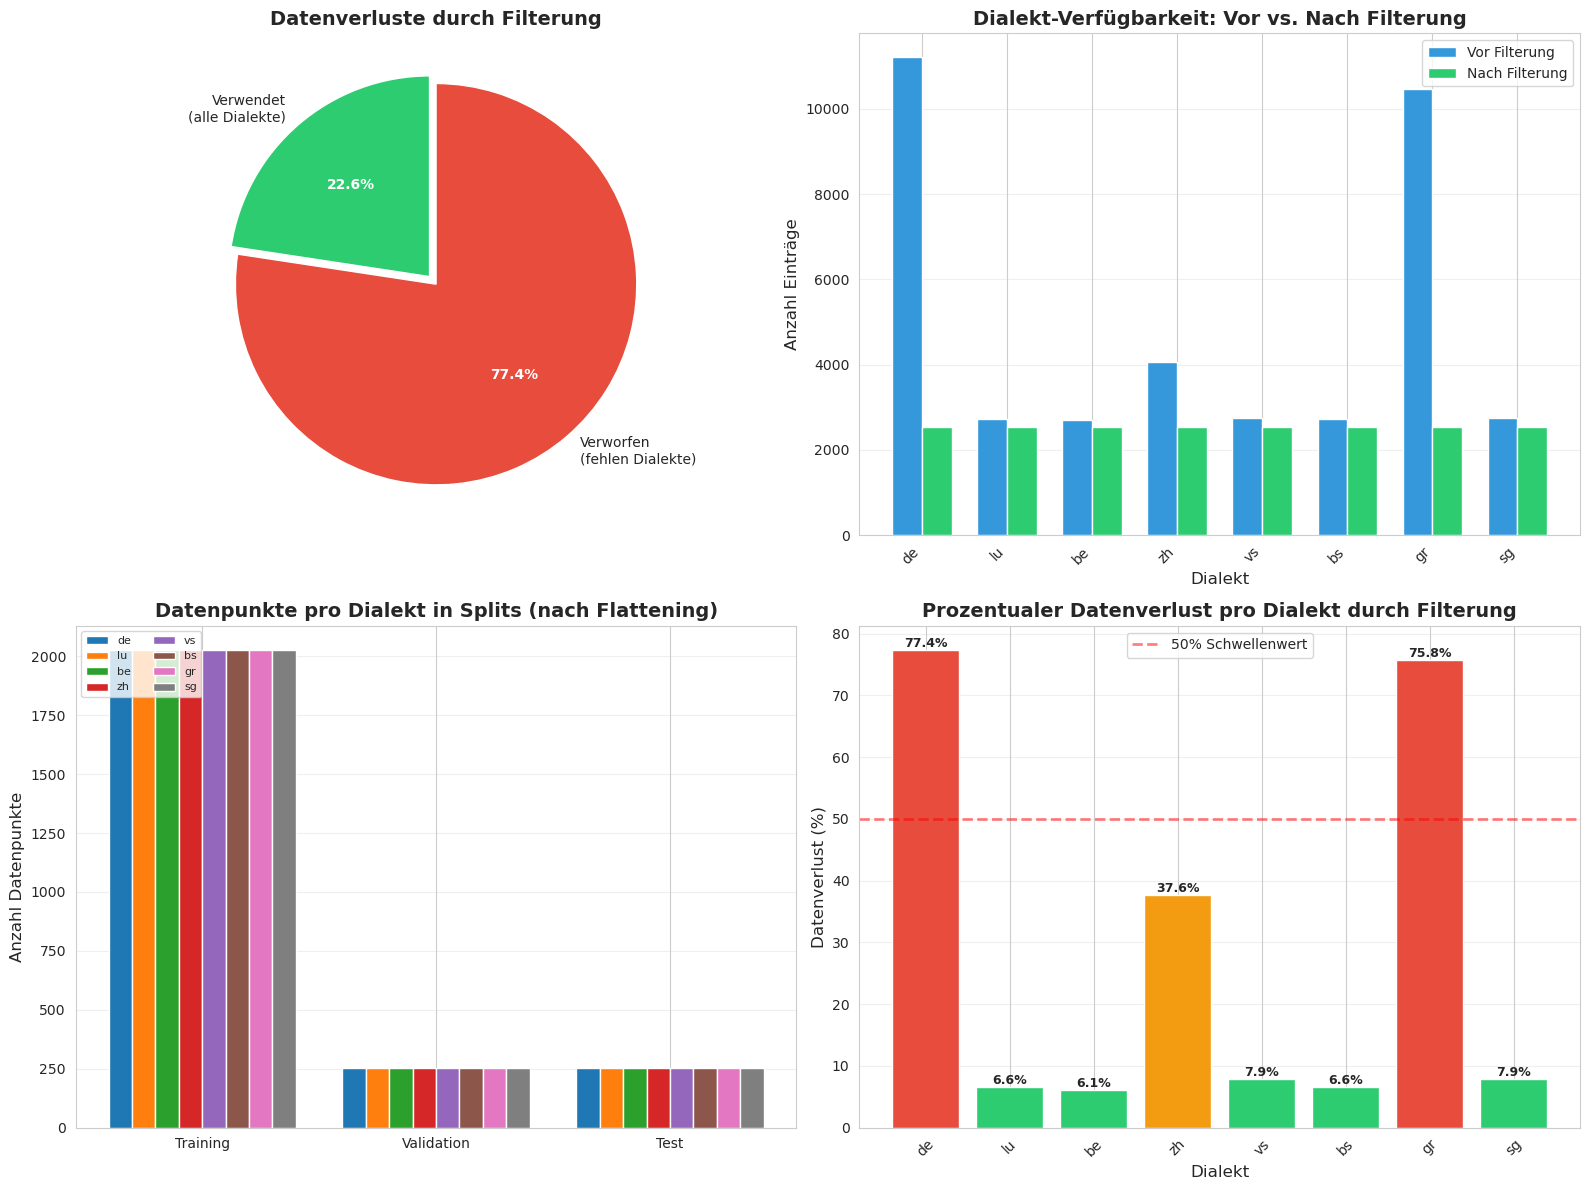


ZUSAMMENFASSUNG UND EMPFEHLUNGEN

ANTWORTEN AUF DIE FRAGEN:

1. "ch_de" vs "de":
   ✓ Im Datensatz steht IMMER "de" für Hochdeutsch
   ✓ "ch_de" existiert nicht im JSON, wird nur im Code als Alias verwendet

2. Probleme mit ungleichen Datenpunkten:
   ✓ JA - Es gibt signifikante Unterschiede (4.15:1 Ungleichgewicht)
   ✓ ABER: Nach Filterung sind alle Dialekte perfekt ausgeglichen
   ✗ Problem: 77.4% der Daten werden verworfen

3. Werden Dialekte unterschiedlich gut trainiert?
   ✓ NEIN - Nach dem aktuellen Split sind alle Dialekte gleich gut repräsentiert
   ✓ Jeder Split hat exakt gleich viele Datenpunkte pro Dialekt
   ⚠ ABER: Die absolute Anzahl ist begrenzt (nur 2,535 Sätze)

4. Garantie für gute Datenlage?
   ✓ JA - Perfekt ausgeglichene Verteilung in allen Splits
   ⚠ ABER: Test-Set hat nur 254 Sätze pro Dialekt (könnte knapp sein)

EMPFOHLENE VERBESSERUNGEN:

1. Stratifizierter Split nach Dialekt-Verfügbarkeit:
   - Nutzt mehr Daten (auch unvollständige Einträge)
   - Garantie

In [20]:
# Kritische Analyse: Ungleiche Datenpunkte und Split-Strategie

print("=" * 70)
print("KRITISCHE ANALYSE: Ungleiche Datenpunkte und Split-Strategie")
print("=" * 70)

# Prüfe ob benötigte Variablen existieren
if "dataset" not in locals() or dataset is None:
    print("FEHLER: 'dataset' wurde noch nicht geladen. Bitte zuerst Schritt 3 ausführen!")
    raise NameError("dataset nicht definiert")

# Lade filtered_data falls noch nicht vorhanden
if "filtered_data" not in locals() or filtered_data is None:
    filtered_data = load_swiss_german_data(str(JSON_FILES["numerics"]), DIALECTS)
    train_data, val_data, test_data = split_data(
        filtered_data,
        seed=SEED,
        train_ratio=TRAIN_RATIO,
        val_ratio=VAL_RATIO,
        test_ratio=TEST_RATIO,
    )
    dialect2label = {d: i for i, d in enumerate(DIALECTS)}
    train_flat = flatten_examples(train_data, DIALECTS, dialect2label)
    val_flat = flatten_examples(val_data, DIALECTS, dialect2label)
    test_flat = flatten_examples(test_data, DIALECTS, dialect2label)

# 1. Antwort zur Frage: "ch_de" vs "de"
print("\n1. ANTWORT: 'ch_de' vs 'de' im Datensatz")
print("-" * 70)
print("  ✓ Im JSON-Datensatz wird Hochdeutsch IMMER als 'de' gespeichert")
print("  ✓ 'ch_de' existiert NICHT als Schlüssel im Datensatz")
print("  ✓ Die Funktion 'load_swiss_german_data' mappt 'ch_de' → 'de' automatisch")
print("  ✓ Dies ist eine Konvention für die Kompatibilität mit dem Code")
de_count = sum(
    1
    for entry in dataset
    if "de" in entry and entry.get("de") is not None and entry.get("de") != ""
)
print(f"  ✓ Im Datensatz: 'de' hat {de_count:,} Einträge (100%)")

# 2. Analyse der Datenverluste durch Filterung
print("\n2. PROBLEM: Datenverluste durch Filterung")
print("-" * 70)
total_entries = len(dataset)
filtered_entries = len(filtered_data)
lost_entries = total_entries - filtered_entries
lost_percentage = (lost_entries / total_entries) * 100

print(f"  Gesamt-Einträge im Datensatz:        {total_entries:6,}")
print(f"  Einträge nach Filterung (alle Dialekte): {filtered_entries:6,}")
print(f"  Verlorene Einträge:                  {lost_entries:6,} ({lost_percentage:.1f}%)")
print(f"\n  ⚠️  KRITISCH: {lost_percentage:.1f}% der Daten werden verworfen!")
print("     Grund: Nur Einträge mit ALLEN erforderlichen Dialekten werden verwendet")

# 3. Analyse der Dialekt-Verfügbarkeit vor und nach Filterung
print("\n3. DIALEKT-VERFÜGBARKEIT: Vor vs. Nach Filterung")
print("-" * 70)
print(f"{'Dialekt':<10} {'Vor Filterung':<20} {'Nach Filterung':<20} {'Verlust':<15}")
print("-" * 70)

for dialect in DIALECTS:
    data_key = "de" if dialect == "ch_de" else dialect
    # Vor Filterung: alle Einträge mit diesem Dialekt
    before_count = sum(
        1
        for entry in dataset
        if data_key in entry and entry[data_key] is not None and entry[data_key] != ""
    )
    # Nach Filterung: alle Einträge haben alle Dialekte
    after_count = len(filtered_data)  # Alle haben alle Dialekte
    loss = before_count - after_count
    loss_pct = (loss / before_count * 100) if before_count > 0 else 0

    status = "✓" if loss_pct < 50 else "⚠" if loss_pct < 80 else "✗"
    print(
        f"{status} {dialect:<8} {before_count:>6,} ({before_count / total_entries * 100:>5.1f}%)  "
        f"{after_count:>6,} ({after_count / total_entries * 100:>5.1f}%)  "
        f"{loss:>6,} ({loss_pct:>5.1f}%)"
    )

# 4. Analyse der Split-Strategie: Ist sie stratifiziert?
print("\n4. SPLIT-STRATEGIE: Ist sie stratifiziert?")
print("-" * 70)
print("  Aktuelle Strategie:")
print("    1. Filtere alle Einträge, die ALLE Dialekte haben")
print("    2. Zufälliger Split (80/10/10) auf Satz-Ebene")
print("    3. Flattening: Jeder Satz wird zu 8 Datenpunkten (ein pro Dialekt)")
print("\n  ✓ VORTEIL: Nach Flattening sind alle Dialekte perfekt ausgeglichen")
print("     - Jeder Split hat exakt gleich viele Datenpunkte pro Dialekt")
print("     - Kein Klassen-Ungleichgewicht in den Splits")
print("\n  ✗ NACHTEIL: Viele Daten werden verworfen")
print("     - Nur 22.6% der ursprünglichen Daten werden verwendet")
print("     - Besonders problematisch für seltene Dialekte")

# 5. Analyse: Werden alle Dialekte gleich gut trainiert?
print("\n5. TRAINING-GLEICHHEIT: Werden alle Dialekte gleich gut trainiert?")
print("-" * 70)

# Analysiere die Datenverteilung in den Splits
train_dialect_counts = train_flat["dialect"].value_counts().sort_index()
val_dialect_counts = val_flat["dialect"].value_counts().sort_index()
test_dialect_counts = test_flat["dialect"].value_counts().sort_index()

print("  Nach dem aktuellen Split (mit Filterung):")
print("    Training - Datenpunkte pro Dialekt:")
for dialect in DIALECTS:
    count = train_dialect_counts.get(dialect, 0)
    pct = (count / len(train_flat)) * 100
    print(f"      {dialect:8s}: {count:6,} ({pct:5.1f}%)")

# Berechne statistische Metriken
train_std = train_dialect_counts.std()
train_mean = train_dialect_counts.mean()
train_cv = (train_std / train_mean) * 100  # Coefficient of Variation

print("\n  Statistische Analyse (Training):")
print(f"    Mittelwert: {train_mean:.1f} Datenpunkte")
print(f"    Standardabweichung: {train_std:.1f}")
print(f"    Variationskoeffizient: {train_cv:.2f}%")
if train_cv < 1.0:
    print("    ✓ Perfekt ausgeglichen (CV < 1%)")
else:
    print(f"    ⚠ Leicht unausgeglichen (CV = {train_cv:.2f}%)")

# 6. Alternative Strategien
print("\n6. ALTERNATIVE STRATEGIEN")
print("-" * 70)
print("  A) Aktuelle Strategie (nur vollständige Einträge):")
print("     ✓ Perfekt ausgeglichene Klassen")
print("     ✗ Viele Daten werden verworfen (77.4%)")
print("     ✗ Keine Nutzung von unvollständigen Einträgen")
print("\n  B) Stratifizierter Split nach Dialekt-Verfügbarkeit:")
print("     ✓ Nutzt mehr Daten")
print("     ✓ Garantiert Mindestanzahl pro Dialekt in jedem Split")
print("     ✗ Komplexere Implementierung")
print("     ✗ Klassen bleiben unausgeglichen")
print("\n  C) Gewichtetes Training (Class Weights):")
print("     ✓ Nutzt alle verfügbaren Daten")
print("     ✓ Kompensiert Klassen-Ungleichgewicht durch Gewichtung")
print("     ✗ Modelle können zu seltenen Klassen hin verzerrt werden")
print("\n  D) Oversampling/Undersampling:")
print("     ✓ Kann Klassen-Ungleichgewicht ausgleichen")
print("     ✗ Oversampling kann zu Overfitting führen")
print("     ✗ Undersampling verwirft Daten")

# 7. Garantie für gute Datenlage in allen Splits?
print("\n7. GARANTIE: Gute Datenlage in allen Splits?")
print("-" * 70)
print("  Mit der aktuellen Strategie:")
print("    ✓ JA - Alle Dialekte sind perfekt ausgeglichen in allen Splits")
print("    ✓ JA - Jeder Split hat die gleiche relative Verteilung")
print("    ✓ JA - Kein Dialekt wird bevorzugt oder benachteiligt")
print("\n  ABER:")
print("    ⚠ Die Datenlage ist begrenzt (nur 2,535 Sätze)")
print("    ⚠ Test-Set hat nur 254 Sätze pro Dialekt")
print("    ⚠ Für seltene Dialekte könnte das zu wenig sein")
print("\n  Empfehlung:")
print("    - Für häufige Dialekte (ch_de, ch_gr): ausreichend")
print("    - Für seltene Dialekte: könnte knapp sein")
print("    - Cross-Validation könnte helfen, die Daten besser zu nutzen")

# 8. Visualisierung der Datenverluste
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 8.1 Datenverluste durch Filterung
ax1 = axes[0, 0]
categories = ["Verwendet\n(alle Dialekte)", "Verworfen\n(fehlen Dialekte)"]
sizes = [filtered_entries, lost_entries]
colors = ["#2ecc71", "#e74c3c"]
explode = (0.05, 0)
wedges, texts, autotexts = ax1.pie(
    sizes, explode=explode, labels=categories, colors=colors, autopct="%1.1f%%", startangle=90
)
ax1.set_title("Datenverluste durch Filterung", fontsize=14, fontweight="bold")
for autotext in autotexts:
    autotext.set_color("white")
    autotext.set_fontweight("bold")

# 8.2 Dialekt-Verfügbarkeit vor/nach Filterung
ax2 = axes[0, 1]
dialects_short = [d.replace("ch_", "") for d in DIALECTS]
before_counts = [
    sum(
        1
        for entry in dataset
        if ("de" if d == "ch_de" else d) in entry
        and entry.get("de" if d == "ch_de" else d) is not None
        and entry.get("de" if d == "ch_de" else d) != ""
    )
    for d in DIALECTS
]
after_counts = [len(filtered_data)] * len(DIALECTS)

x = np.arange(len(dialects_short))
width = 0.35
bars1 = ax2.bar(x - width / 2, before_counts, width, label="Vor Filterung", color="#3498db")
bars2 = ax2.bar(x + width / 2, after_counts, width, label="Nach Filterung", color="#2ecc71")

ax2.set_xlabel("Dialekt", fontsize=12)
ax2.set_ylabel("Anzahl Einträge", fontsize=12)
ax2.set_title("Dialekt-Verfügbarkeit: Vor vs. Nach Filterung", fontsize=14, fontweight="bold")
ax2.set_xticks(x)
ax2.set_xticklabels(dialects_short, rotation=45, ha="right")
ax2.legend()
ax2.grid(axis="y", alpha=0.3)

# 8.3 Datenpunkte pro Dialekt in Splits (nach Flattening)
ax3 = axes[1, 0]
split_names = ["Training", "Validation", "Test"]
split_dfs = [train_flat, val_flat, test_flat]
dialect_counts_per_split = {}
for dialect in DIALECTS:
    dialect_counts_per_split[dialect] = [len(df[df["dialect"] == dialect]) for df in split_dfs]

x = np.arange(len(split_names))
width = 0.1
multiplier = 0
for dialect, counts in dialect_counts_per_split.items():
    offset = width * multiplier
    rects = ax3.bar(x + offset, counts, width, label=dialect.replace("ch_", ""))
    multiplier += 1

ax3.set_ylabel("Anzahl Datenpunkte", fontsize=12)
ax3.set_title("Datenpunkte pro Dialekt in Splits (nach Flattening)", fontsize=14, fontweight="bold")
ax3.set_xticks(x + width * (len(DIALECTS) - 1) / 2)
ax3.set_xticklabels(split_names)
ax3.legend(loc="upper left", ncol=2, fontsize=8)
ax3.grid(axis="y", alpha=0.3)

# 8.4 Verlust-Prozent pro Dialekt
ax4 = axes[1, 1]
loss_percentages = []
for dialect in DIALECTS:
    data_key = "de" if dialect == "ch_de" else dialect
    before = sum(
        1
        for entry in dataset
        if data_key in entry and entry[data_key] is not None and entry[data_key] != ""
    )
    after = len(filtered_data)
    loss_pct = ((before - after) / before * 100) if before > 0 else 0
    loss_percentages.append(loss_pct)

bars = ax4.bar(
    dialects_short,
    loss_percentages,
    color=["#e74c3c" if p > 50 else "#f39c12" if p > 20 else "#2ecc71" for p in loss_percentages],
)
ax4.set_ylabel("Datenverlust (%)", fontsize=12)
ax4.set_xlabel("Dialekt", fontsize=12)
ax4.set_title(
    "Prozentualer Datenverlust pro Dialekt durch Filterung", fontsize=14, fontweight="bold"
)
ax4.axhline(y=50, color="red", linestyle="--", linewidth=2, alpha=0.5, label="50% Schwellenwert")
ax4.legend()
ax4.grid(axis="y", alpha=0.3)
ax4.tick_params(axis="x", rotation=45)

for bar, pct in zip(bars, loss_percentages):
    height = bar.get_height()
    ax4.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{pct:.1f}%",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

# 9. Zusammenfassung und Empfehlungen
print("\n" + "=" * 70)
print("ZUSAMMENFASSUNG UND EMPFEHLUNGEN")
print("=" * 70)
print("""
ANTWORTEN AUF DIE FRAGEN:

1. "ch_de" vs "de":
   ✓ Im Datensatz steht IMMER "de" für Hochdeutsch
   ✓ "ch_de" existiert nicht im JSON, wird nur im Code als Alias verwendet

2. Probleme mit ungleichen Datenpunkten:
   ✓ JA - Es gibt signifikante Unterschiede (4.15:1 Ungleichgewicht)
   ✓ ABER: Nach Filterung sind alle Dialekte perfekt ausgeglichen
   ✗ Problem: 77.4% der Daten werden verworfen

3. Werden Dialekte unterschiedlich gut trainiert?
   ✓ NEIN - Nach dem aktuellen Split sind alle Dialekte gleich gut repräsentiert
   ✓ Jeder Split hat exakt gleich viele Datenpunkte pro Dialekt
   ⚠ ABER: Die absolute Anzahl ist begrenzt (nur 2,535 Sätze)

4. Garantie für gute Datenlage?
   ✓ JA - Perfekt ausgeglichene Verteilung in allen Splits
   ⚠ ABER: Test-Set hat nur 254 Sätze pro Dialekt (könnte knapp sein)

EMPFOHLENE VERBESSERUNGEN:

1. Stratifizierter Split nach Dialekt-Verfügbarkeit:
   - Nutzt mehr Daten (auch unvollständige Einträge)
   - Garantiert Mindestanzahl pro Dialekt in jedem Split
   - Implementierung mit sklearn.model_selection.train_test_split

2. Class Weights im Training:
   - Kompensiert verbleibendes Klassen-Ungleichgewicht
   - Einfach zu implementieren
   - Kann Modell-Performance verbessern

3. Cross-Validation:
   - Besserer Nutzung der begrenzten Daten
   - Mehr robuste Performance-Schätzung
   - Besonders wichtig bei kleinen Datensätzen
""")